# 5DEEP: Projet

Pour rappel, cet examen est à réaliser par groupes d'au plus trois étudiants.

Vous devez télécharger et utiliser les jeux de données suivant : train et test (source : Kaggle).

Les données sont des images représentant les lettres de l'alphabet en langue des signes. Les classes indexées de 0 à 25 représentent les lettres de A à Z. À noter qu'il n'y a pas de données pour les lettres J et Z (car on ne les représente pas par des signes statiques mais par des mouvements).

Vous devrez développer "from scratch" vos propres réseaux de neurones pour résoudre ce problème de classification. Utiliser un modèle pré-entrainé n'est autorisé que dans la question correspondante.

Votre rendu se fera sous la forme d'un archive au format .zip contenant un notebook Jupyter (code source), son export au format PDF (ou HTML) ainsi qu'une sauvegarde de votre modèle final. Tout projet ne comportant pas ces trois éléments sera ajourné sans contestation possible.

Toutes les étapes de votre projet devront être commentées et justifiées. Tous les résultats devront être interprétés. La qualité de la rédaction (style, grammaire et orthographe) sera prise en compte. Un rendu professionnel est attendu.

L'usage de Python et de la librairie Tensorflow est obligatoire.

1. Charger les données et les transformer en images de 28 x 28 pixels.
2. Ce dataset est-il équilibré ? Est-il nécessaire de rééquilibrer les données ? Le faire si besoin est.
3. Construire un réseau de neurones convolutif pour résoudre ce problème de classification. Il devra contenir au minimum les éléments suivants : couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées. Vous êtes libres d'ajouter d'autres éléments.
4. Entraîner le modèle construit à la question précédente et mesurer sa performance.
5. Faire une recherche de meilleurs hyperparamètres avec la fonction "GridSearchCV“.
6. Utiliser une technique d'augmentation d'images. Les résultats de vos modèles s'en trouvent-ils améliorés ? Était-ce prévisible ?
7. Sauvegarder votre meilleur modèle.
8. Utiliser votre meilleur modèle avec des photos prises pour l'occasion où vous représenterez différents signes.
9. Choisir un des modèles pré-entrainés disponible avec Keras. Le charger et le personnaliser avec des couches de convolution et complètement connectées. L'entraîner et mesurer sa performance. La comparer avec celles de votre meilleur modèle.

#### 1. Charger les données et les transformer en images de 28 x 28 pixels.

In [106]:
import sys
print(sys.executable)
!{sys.executable} -m pip install scikeras
!{sys.executable} -m pip install pydot

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

/opt/anaconda3/bin/python

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [107]:
# Chargement des données
# path= "/content/drive/My Drive/Colab Notebooks/5DEEP/Project"
X_test = pd.read_csv("./Sign MNIST Test.csv")
train_data = pd.read_csv("./Sign MNIST Training Data.csv")

target= "label"

"label" est un nombre compris entre 0 et 26 qui correspond à la letttre représentée sur l'image.

In [108]:
X_test.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


On voit que chaque ligne correspond à une image consituée de la manière suivante:
- label => nombre correspondant à la lettre,
- 784 * pixel => nombre compris entre 0 et 255, correspondant à des échelles de gris (0 = noir, 256 = blanc)

NB: 1 pixel = 1 octet = 8 bits -> peuvent prendre 2 valeurs (0 ou 1) => 2^8 = 256 valeurs possibles en tout.

In [109]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27455 entries, 0 to 27454
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 164.4 MB


On a en tout 27 454 observations.

#### 2. Ce dataset est-il équilibré ? Est-il nécessaire de rééquilibrer les données ? Le faire si besoin est.

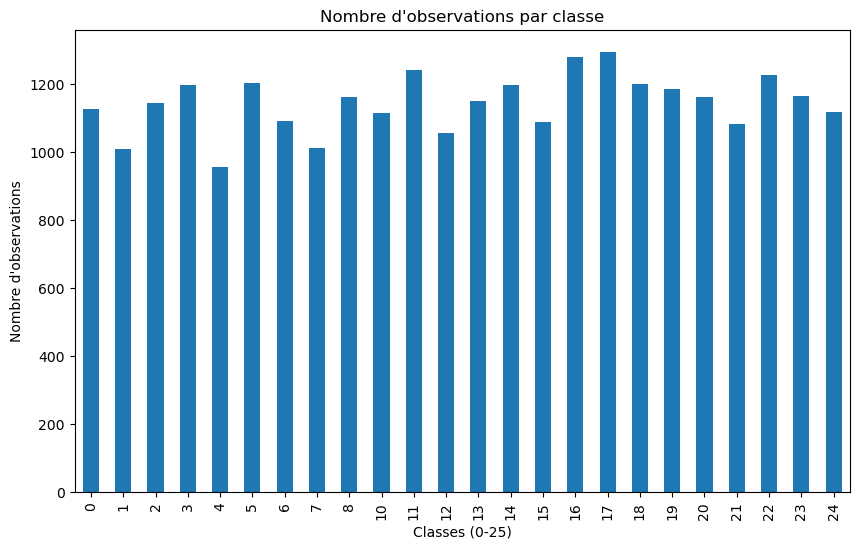

label
0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: count, dtype: int64


In [110]:
# Compter le nombre d'observations par classe dans la colonne 'label'
label_counts = train_data[target].value_counts().sort_index()

# Visualiser les résultats sous forme de graphique
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
label_counts.plot(kind='bar')
plt.title("Nombre d'observations par classe")
plt.xlabel("Classes (0-25)")
plt.ylabel("Nombre d'observations")
plt.show()

# Afficher le nombre précis d'observations pour chaque classe/lettre
print(label_counts)

Globalement le dataset est équilibré (il ne manque pas énormément de données à l'une des classe par exemple). La lettre 4 est la moins représentée parmi celles du graphique (957 observations).
Vu qu'il y a un set de validation à faire, je vais prendre toutes les valeurs excédant 900 pour en faire le set de validation. (ce qui garantit qu'il y aura au minimum 57 représentants pour chaque lettre dans le dataset de validation)

Comme indiqué dans l'énoncé, on voit bien qu'il n'y a pas de J (lettre 9) et pas de Z (lettre 25).

In [111]:
# Création des datasets train/tests/val si pas de rééquilibrage à faire

# from sklearn.model_selection import train_test_split

# # Créer à partir de X_train un X_val = redéfinir X_train et définir X_val
# X_train, X_val = train_test_split(train_data, test_size=1/6)

# y_train = X_train[target]
# y_test = X_test[target]
# y_val = X_val[target]

# print("Taille du jeu d'entraînement :", X_train.shape, y_train.shape)
# print("Taille du jeu de validation :", X_val.shape, y_val.shape)
# print("Taille du jeu de test :", X_test.shape, y_test.shape)

Comme je dois créer un set de validation, je préfère créer un X_train comprenant 900 observation par lettre (sauf J et Z qui ne sont pas représentés), ce qui permettra d'entrainer de manière parfaitement équitable sur toutes les lettres et d'avoir toutes les observations en excès pour le dataset de validation.

In [112]:
# Equilibrer et créer X_val
nb_obs_by_class = 900

# Initialiser des DataFrames pour les données équilibrées et les excédents
X_train = pd.DataFrame()
X_val = pd.DataFrame()

# Pour chaque classe, équilibrer les données
for label in train_data[target].unique():
    # Filtrer les observations pour chaque label (lettre)
    class_data = train_data[train_data[target] == label]

    # S'assurer qu'il n'y ait pas d'ordre dans les observations
    class_data = class_data.sample(frac=1, random_state=42).reset_index(drop=True)

    # Prendre 900 observations pour le dataset équilibré (elles iront dans X_train)
    balanced_class_data = class_data.iloc[:nb_obs_by_class]

    # Mettre à part les données excédentaires (elles iront dans X_val)
    excess_class_data = class_data.iloc[nb_obs_by_class:]

    # Ajouter au DataFrame global
    X_train = pd.concat([X_train, balanced_class_data], ignore_index=True)
    X_val = pd.concat([X_val, excess_class_data], ignore_index=True)

# Vérifier que le dataset est équilibré => il doit y avoir 900 obs par lettre
print(X_train[target].value_counts())

# Vérifier les données excédentaires 
print(X_val[target].value_counts())

label
3     900
6     900
7     900
5     900
0     900
4     900
15    900
11    900
12    900
1     900
24    900
23    900
21    900
19    900
17    900
20    900
10    900
18    900
22    900
8     900
16    900
13    900
2     900
14    900
Name: count, dtype: int64
label
17    394
16    379
11    341
22    325
5     304
18    299
3     296
14    296
19    286
23    264
8     262
20    261
13    251
2     244
0     226
24    218
10    214
6     190
15    188
21    182
12    155
7     113
1     110
4      57
Name: count, dtype: int64


Sur l'ensemble des datas, vérifier la répartition des observations entre les datasets d'entrainement, de test et de validation.

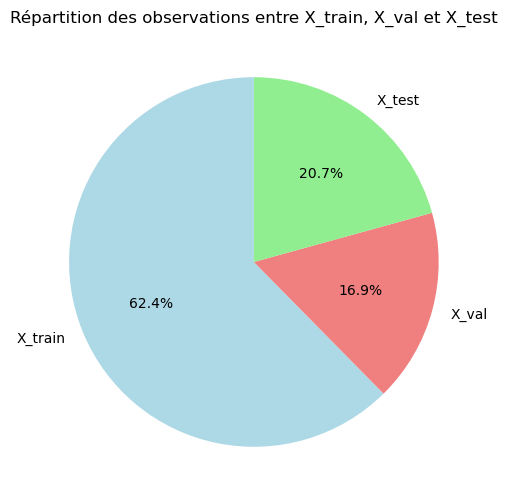

In [113]:
def plot_pie_dataset_length (train_dataset, val_dataset, test_dataset):
  # Compter le nombre total d'observations dans X_train, X_val et X_Test
  train_size = len(train_dataset)
  val_size = len(val_dataset)
  test_size = len(test_dataset)

  # Créer les labels et les tailles pour le camembert
  labels = ['X_train', 'X_val', 'X_test']
  sizes = [train_size, val_size, test_size]

  # Créer le graphique camembert
  plt.figure(figsize=(6, 6))
  plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'lightcoral', 'lightgreen'])

  plt.title("Répartition des observations entre X_train, X_val et X_test")
  plt.show()

plot_pie_dataset_length(X_train, X_val, X_test)

=> respecte à peu près la répartition 60(train) : 20 (val) : 20 (test).

In [114]:
# Vérification de la taille des datasets
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(21600, 785)
(5855, 785)
(7172, 785)


Il faut maintenant enlever les colonnes target "label" des datasets X_ et les isoler dans les variables y_.

In [115]:
target="label"

# Création des y
y_train = X_train[target]
y_test = X_test[target]
y_val = X_val[target]

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

# Création des x sans la colonne "target"
X_train = X_train.drop(columns=[target])
X_test = X_test.drop(columns=[target])
X_val = X_val.drop(columns=[target])

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(21600,)
(7172,)
(5855,)
(21600, 784)
(7172, 784)
(5855, 784)


#### 1. Redimensionner les images en 28*28.

In [116]:
# Taille de l'image souhaitée
image_w = 28
image_h = 28

# Dictionnaire pour associer les classes à des lettres (pas de J ni Z)
labels = {
    0 : "A", 1 : "B", 2 : "C", 3 : "D", 4 : "E", 5 : "F",
    6 : "G", 7 : "H", 8 : "I", 9 : "J", 10 : "K", 11 : "L",
    12 : "M", 13 : "N", 14 : "O", 15 : "P", 16 : "Q", 17 : "R",
    18 : "S", 19 : "T", 20 : "U", 21 : "V", 22 : "W", 23 : "X",
    24 : "Y", 25 : "Z"
}

# Redimensionner X_train, X_test, et X_val en 28x28 (nb obs, 28, 28)
X_train_image = X_train.to_numpy().reshape(X_train.shape[0], image_w, image_h)
X_test_image = X_test.to_numpy().reshape(X_test.shape[0], image_w, image_h)
X_val_image = X_val.to_numpy().reshape(X_val.shape[0], image_w, image_h)

# Vérification des nouvelles dimensions
print(X_train_image.shape)  # (nombre d'observations, 28, 28)
print(X_test_image.shape)   # (nombre d'observations, 28, 28)
print(X_val_image.shape)    # (nombre d'observations, 28, 28)

(21600, 28, 28)
(7172, 28, 28)
(5855, 28, 28)


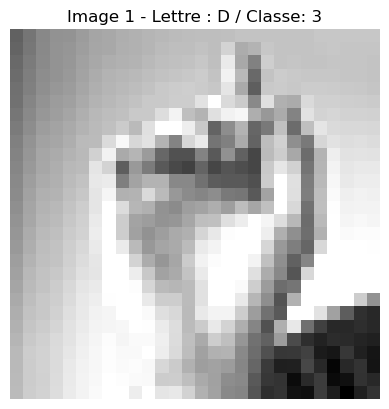

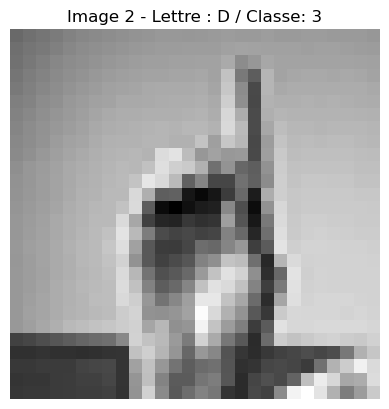

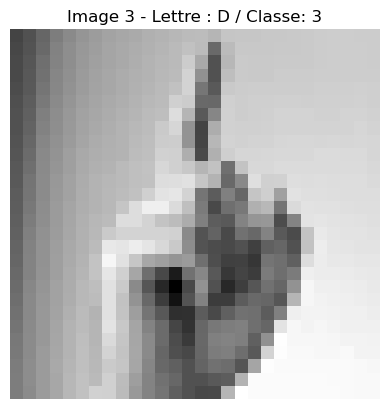

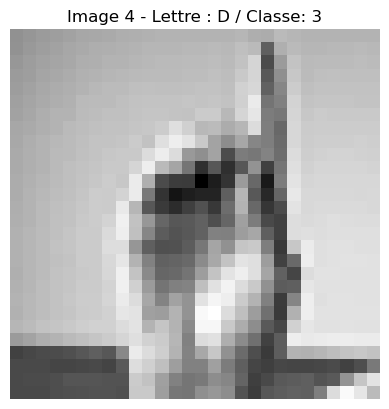

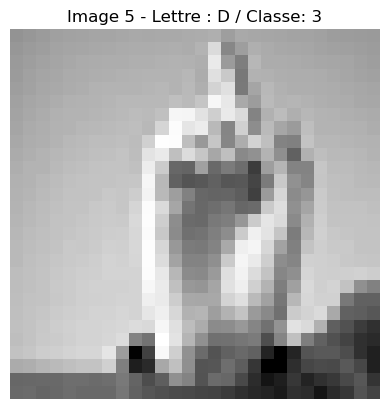

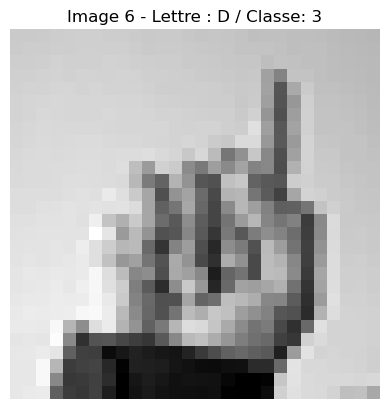

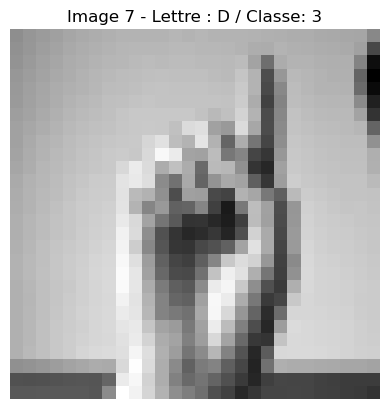

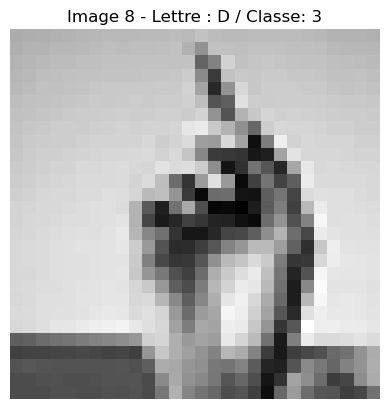

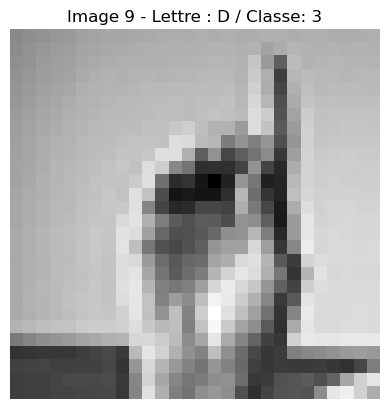

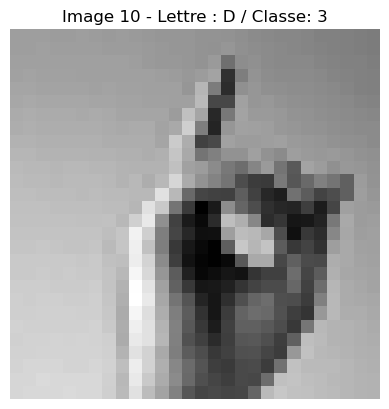

In [117]:
# Afficher les 10 premières images et leurs labels correspondants
for i in range(10):
    # Afficher la lettre correspondant à l'image (avec iloc pour accéder à l'index correct dans y_train
    label = labels[y_train.iloc[i]]

    # Afficher l'image correspondante
    plt.imshow(X_train_image[i], cmap="gray")
    plt.title(f"Image {i+1} - Lettre : {label} / Classe: {y_train.iloc[i]}")
    plt.axis('off')  # Suprimme les axes = pas besoin ici
    plt.show()


#### 3. Construire un réseau de neurones convolutif pour résoudre ce problème de classification. Il devra contenir au minimum les éléments suivants : couches de convolution, couche de "pooling", "dropout", couches cachées complètement connectées. Vous êtes libres d'ajouter d'autres éléments.

##### Prétraitement

Normalisation des données : les valeurs des pixels sont entre 0 et 255, on les divise par 255 pour les ramener entre 0 et 1.


In [118]:
X_train_norm = X_train / 255.0
X_test_norm = X_test / 255.0
X_val_norm = X_val / 255.0

print("~~~ X_train")
print(X_train_norm.shape)
print(X_train_norm.head(1))
print("~~~ X_test")
print(X_test_norm.shape)
print(X_test_norm.head(1))
print("~~~ X_val")
print(X_val_norm.shape)
print(X_val_norm.head(1))

~~~ X_train
(21600, 784)
     pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
0  0.505882  0.568627  0.627451  0.658824  0.666667  0.690196  0.717647   

     pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  pixel778  \
0  0.729412  0.745098  0.756863  ...  0.466667   0.34902  0.368627  0.262745   

   pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
0   0.25098  0.396078  0.294118  0.203922  0.305882  0.364706  

[1 rows x 784 columns]
~~~ X_test
(7172, 784)
     pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
0  0.584314  0.584314  0.588235  0.588235  0.588235  0.592157  0.592157   

     pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  pixel778  \
0  0.588235  0.592157  0.596078  ...  0.541176  0.580392  0.498039   0.34902   

   pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
0  0.321569  0.376471  0.415686  0.439216  0.470588  0.419608  

[1 rows x 784 columns]
~~~ X_val
(5855, 784)
  

Ici, le but est de changer la colonne label qui contient des valeurs entre 0 et 25 en une matrice où chaque ligne correspond à une observation et chaque colone correspond à une lettre. Toutes les colonnes seront à 0 sauf celle qui désigne la lettre de l'observation (qui elle sera à 1).

Pouyr cela, on va utiliser la fonction to_categorical qui réalise un one-hot encoding.

In [119]:
from tensorflow.keras.utils import to_categorical 

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

# convertir des labels entiers (catégories) en une représentation one hot encoding (vecteur de taille n pour le nb de classes, rempli de 0 sauf pour la bonne classe = 1)
y_train_cat = to_categorical(y_train, num_classes=len(labels))
y_val_cat = to_categorical(y_val, num_classes=len(labels))
y_test_cat = to_categorical(y_test, num_classes=len(labels))

print(y_train_cat.shape)
print(y_val_cat.shape)
print(y_test_cat.shape)

(21600,)
(5855,)
(7172,)
(21600, 26)
(5855, 26)
(7172, 26)


##### Evaluation des modèles

La fonction "plot_history" va permettre de repésenter les métriques loss et accuracy pour les modèles de classification entrainés pour le dataset d'entrainement et le dataset de valisation.

NB: les métriques:
- loss (fonction de coût) : mesure à quel point les prédictions du modèle diffèrent des valeurs réelles. => plus il est faible, plus les prédictions sont proches de la réalité (faire attention que le loss de la validation ne soit pas beaucoup plus élevé = overfiting)
- accuracy (précision) : correspond au pourcentage de prédictions correctes parmi l'ensemble des classes possibles (dans ce cas, les 26 lettres). => Plus l'accuracy est proche de 1 (= 100%), mieux c'est.

In [120]:
from tensorflow.keras.utils import plot_model

def plot_history(history):
    fig, axes = plt.subplots(1,2, figsize=(15,6))
    hist_data = history.history
    hist_data["epochs"] = list(range(1, len(history.history["loss"])+1))

    hist_data = pd.DataFrame(hist_data)
    sns.lineplot(data=hist_data, x="epochs", y="loss", ax=axes[0], color = "blue")
    sns.lineplot(data=hist_data, x="epochs", y="val_loss", ax=axes[0], color = "orange")

    sns.lineplot(data=hist_data, x="epochs", y="categorical_accuracy", ax=axes[1], color = "blue")
    sns.lineplot(data=hist_data, x="epochs", y="val_categorical_accuracy", ax=axes[1], color = "orange")


In [121]:
def compare_predict_true_labels(y_pred, obs_nb = 10):
    for i in range(obs_nb):
        # Affichage de la classe prédite
        print(f"Classe prédite: {labels[np.argmax(y_pred[i])]}")

        # Affichage de la classe réelle
        print(f"Classe vraie  : {labels[np.argmax(y_test_cat[i])]}")

        # Redimensioner l'image de test
        img_norm = X_test_norm.iloc[i].to_numpy().reshape(image_w, image_h)

        # Affichage de l'image
        plt.imshow(img_norm, cmap="gray")
        plt.show()


On crée un dictionnaire "performances" qui va stocker les scores des différents modèles pour pouvoir les comparer facilement.
On va aussi stocker les modèles dans un objet "models" pour pouvoir réutiliser facilement chaque modèle.

In [122]:
performances = {}
models = {}

def evaluate_model(model, name, history):
    # Convertir X_test_norm en tableau numpy
    X_test_norm_np = X_test_norm.to_numpy()

    # Vérifier la forme de X_test_norm et le reformater si nécessaire
    if X_test_norm_np.shape[1] == 784:
        X_test_norm_reshaped = X_test_norm_np.reshape(-1, 28, 28, 1)
    else:
        X_test_norm_reshaped = X_test_norm_np

    # Effectuer les prédictions avec les données formatées
    y_pred = model.predict(X_test_norm_reshaped)

    compare_predict_true_labels(y_pred)

    # Afficher la structure du modèle
    plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        show_trainable=True)

    # Évaluer le modèle avec les données formatées
    loss, categorical_accuracy = model.evaluate(X_test_norm_reshaped, y_test_cat)
    performances[name] = {"Loss" : loss, "Accuracy": categorical_accuracy}

    # Ajouter le modèle à l'objet models
    models[name] = model

    # Tracer l'historique
    plot_history(history)
    print(performances)

##### Création d'un modèle de convolution

In [123]:
X_train_image = X_train_norm.to_numpy().reshape(X_train_norm.shape[0], image_w, image_h, 1) # nb lignes, 28, 28, 1   (nb ligne, width, heigth, nb canaux)
X_val_image = X_val_norm.to_numpy().reshape(X_val_norm.shape[0], image_w, image_h, 1)
X_test_image = X_test_norm.to_numpy().reshape(X_test_norm.shape[0], image_w, image_h, 1)

input_shape = X_train_image.shape[1:]
print(input_shape) # nb de features qui caractérisent une image/ligne

output_dim = y_train_cat.shape[1]
print(output_dim) # vecteur de 26 composantes => lettre entre 0 et 25 / nb de valeurs possibles pour la target 

(28, 28, 1)
26


In [124]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def create_cnn_model():
  model = Sequential()

  model.add(Input(shape=input_shape))

  # Première couche de convolution (32 filtres, 3x3 noyau, activation ReLU)
  model.add(Conv2D(32, (3, 3), activation='relu'))
  # Couche de pooling pour réduire la taille des images (2x2) tout en conservant les informations les plus importantes.
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Applatir les sorties des convolutions pour passer aux couches denses
  model.add(Flatten())

  # Couche entièrement connectée (128 neurones, activation ReLU)
  model.add(Dense(128, activation='relu'))
  # Dropout pour éviter l'overfitting: probabilité de 0.5 est appliquée ici pour désactiver aléatoirement 50 % des neurones pendant l'entraînement, ce qui aide à prévenir l'overfitting.
  model.add(Dropout(0.5))
  # Couche de sortie avec 26 neurones (pour 26 classes = 26 lettres de l'alphabet), activation softmax pour la classification multi-classes
  model.add(Dense(output_dim, activation='softmax'))

  model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

  model.summary()

  return model

model_cnn = create_cnn_model()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_25 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,538 (439.60 KB)

 Trainable params: 112,538 (439.60 KB)

 Non-trainable params: 0 (0.00 B)

#### 4. Entraîner le modèle construit à la question précédente et mesurer sa performance.

In [125]:
print(X_train_image.shape)
print(X_val_image.shape)

(21600, 28, 28, 1)
(5855, 28, 28, 1)


In [126]:
from tensorflow.keras.callbacks import EarlyStopping

history_cnn = model_cnn.fit(
    X_train_image,
    y_train_cat,
    epochs=20,
    validation_data=(X_val_image, y_val_cat),
    callbacks=[EarlyStopping(patience=5)]
)

Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.1633 - loss: 2.7702 - val_categorical_accuracy: 0.7956 - val_loss: 0.7236
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - categorical_accuracy: 0.7283 - loss: 0.7903 - val_categorical_accuracy: 0.9216 - val_loss: 0.2516
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - categorical_accuracy: 0.8846 - loss: 0.3397 - val_categorical_accuracy: 0.9728 - val_loss: 0.0912
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.9393 - loss: 0.1862 - val_categorical_accuracy: 0.9945 - val_loss: 0.0311
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.9679 - loss: 0.1047 - val_categorical_accuracy: 0.9974 - val_loss: 0.0125
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.9768 - loss: 0.0760 - val_categorical_accuracy: 0.9957 - val_loss: 0.0161
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - categorical_accuracy: 0.9801 - los

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Classe prédite: G
Classe vraie  : G


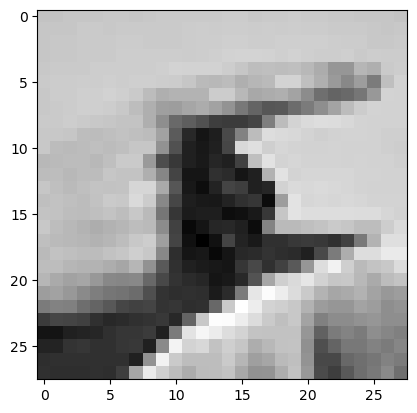

Classe prédite: F
Classe vraie  : F


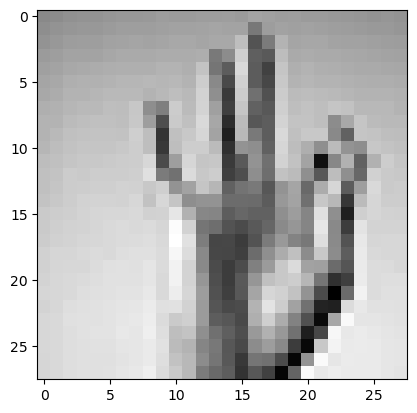

Classe prédite: K
Classe vraie  : K


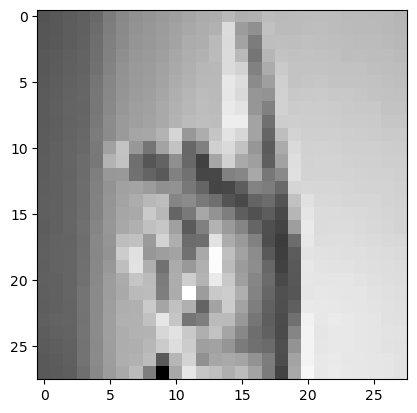

Classe prédite: A
Classe vraie  : A


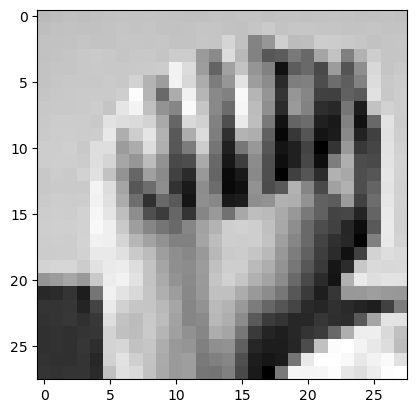

Classe prédite: D
Classe vraie  : D


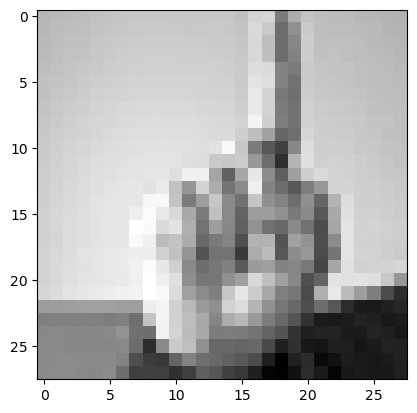

Classe prédite: V
Classe vraie  : V


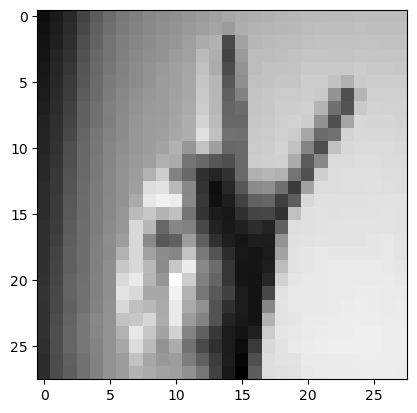

Classe prédite: K
Classe vraie  : K


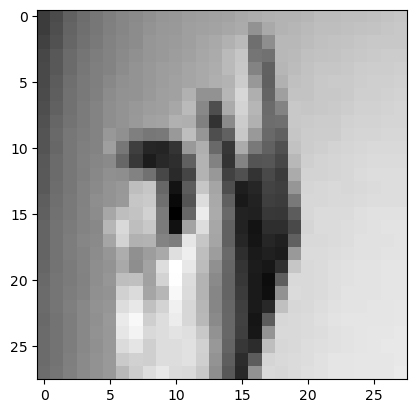

Classe prédite: O
Classe vraie  : O


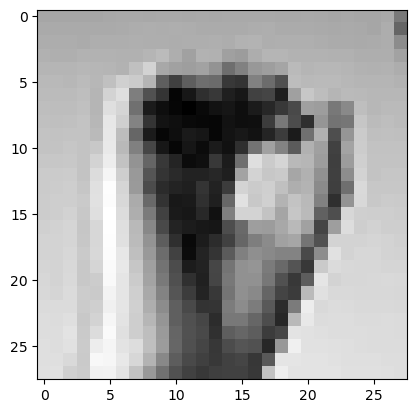

Classe prédite: D
Classe vraie  : D


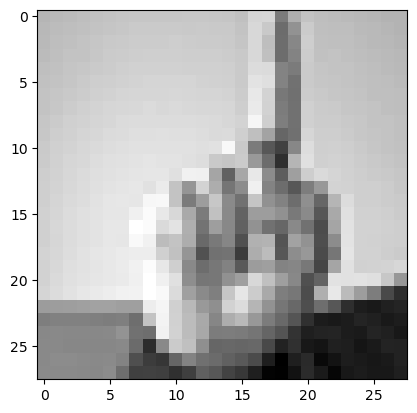

Classe prédite: H
Classe vraie  : H


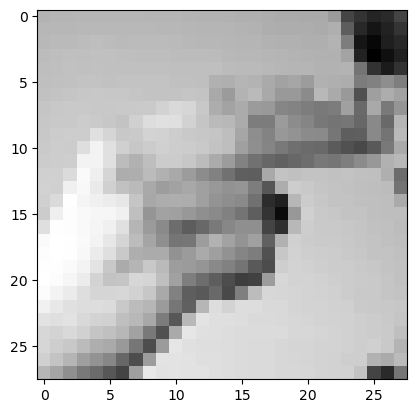

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.9202 - loss: 0.4272
{'CNN': {'Loss': 0.4290611147880554, 'Accuracy': 0.9187116622924805}}


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

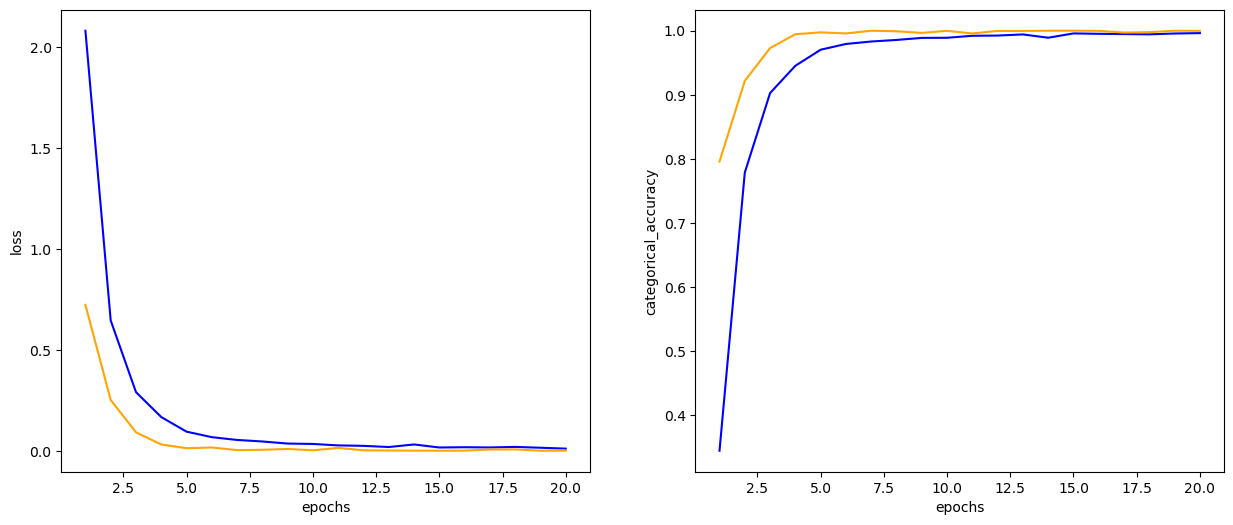

In [127]:
evaluate_model(model_cnn, "CNN", history_cnn)

In [128]:
performances

{'CNN': {'Loss': 0.4290611147880554, 'Accuracy': 0.9187116622924805}}

Pour les deux courbes, les valeurs semblent cohérentes que ce soit pour le dataset d'entranement ou celui de validation : les deux courbes prennent la même trajectoire.

Le loss ne fait que décroitre au fill des epochs jusqu'à atteindre un plateau vers la 7ème epoch. => pas d'overfiting à première vue.

L'accuracy ne fait qu'augmenter jusq'à s'approcher fortement de 1.

#### 5. Faire une recherche de meilleurs hyperparamètres avec la fonction "GridSearchCV“.

##### Vérification du jeu de données d'entrainement

In [129]:
print(X_train_image.shape)
print(y_train_cat.shape)

(21600, 28, 28, 1)
(21600, 26)


In [130]:
print(type(X_train_image))
print(type(y_train_cat))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [131]:
# print(X_train_image)
print(y_train_cat[23])

[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]


In [132]:
print(X_train_image[23])

[[[0.6627451 ]
  [0.6745098 ]
  [0.67843137]
  [0.68235294]
  [0.68627451]
  [0.69411765]
  [0.69803922]
  [0.70588235]
  [0.70588235]
  [0.70588235]
  [0.70980392]
  [0.70980392]
  [0.70588235]
  [0.71372549]
  [0.70588235]
  [0.70980392]
  [0.70196078]
  [0.69803922]
  [0.70196078]
  [0.70196078]
  [0.69803922]
  [0.69411765]
  [0.69019608]
  [0.68235294]
  [0.67843137]
  [0.66666667]
  [0.6627451 ]
  [0.65882353]]

 [[0.6745098 ]
  [0.68235294]
  [0.69019608]
  [0.69803922]
  [0.70196078]
  [0.70980392]
  [0.71372549]
  [0.71372549]
  [0.71764706]
  [0.71764706]
  [0.72156863]
  [0.71764706]
  [0.71764706]
  [0.71764706]
  [0.71764706]
  [0.71372549]
  [0.72156863]
  [0.70980392]
  [0.71372549]
  [0.70588235]
  [0.70196078]
  [0.70196078]
  [0.70196078]
  [0.69803922]
  [0.69019608]
  [0.67843137]
  [0.6745098 ]
  [0.66666667]]

 [[0.67843137]
  [0.69019608]
  [0.70196078]
  [0.70588235]
  [0.71372549]
  [0.71764706]
  [0.72156863]
  [0.7254902 ]
  [0.7254902 ]
  [0.72941176]
  [0.7

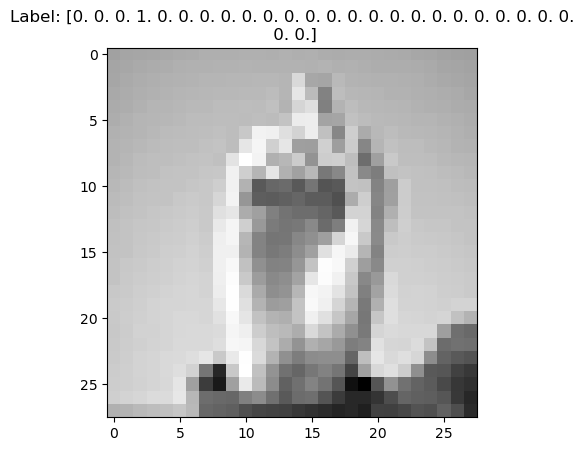

In [133]:
# Visualiser l'image avec son label
index = 23  # ou tout autre index
plt.imshow(X_train_image[index].reshape(28, 28), cmap='gray')
plt.title(f"Label: {y_train_cat[index]}")
plt.show()


##### Mise en place du gridSearchCV

In [134]:
print(input_shape)
print(output_dim)

(28, 28, 1)
26


In [135]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, BackupAndRestore, CSVLogger, Callback
from tensorflow.keras.layers import BatchNormalization

from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV

def create_grid_cnn_model(
    optimizer='adam',
    dropout_rate=0.5,
    neurons=32,
    nb_conv_layers=3,
    alpha=0.01
):
    hyperparameters = {optimizer, dropout_rate, neurons, nb_conv_layers, alpha}
    print("Essais avec :", hyperparameters)
    model = Sequential()

    # Calcul du nombre de filtres en double-entonnoir
    # # ex: pour nb_conv_layers=3 : [8, 16, 8] // pour nb_conv_layers = 6: [8, 16, 32, 64, 32, 16]
    # if nb_conv_layers % 2 == 0:
    #     filter_sizes = [2**(3+i) for i in range(nb_conv_layers//2)] + \
    #                    [2**(3+i) for i in range(nb_conv_layers//2-1, -1, -1)]
    # else:
    #     filter_sizes = [2**(3+i) for i in range((nb_conv_layers+1)//2)] + \
    #                    [2**(3+i) for i in range((nb_conv_layers-1)//2-1, -1, -1)]

    # Boucle pour ajouter les couches de convolution et de pooling
    
    model.add(Input(shape=input_shape))
    
    for i in range(nb_conv_layers):
        model.add(Conv2D(neurons, kernel_size=(3, 3), activation='relu'))
        model.add(BatchNormalization())  # Normalisation après chaque couche Conv

    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Couches denses
    model.add(Flatten())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(26, activation='softmax'))  # 26 classes pour la sortie

    # Configuration de l'optimiseur avec le taux d'apprentissage (alpha)
    if optimizer == 'adam':
        opt = Adam(learning_rate=alpha)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=alpha)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=alpha, momentum=0.1)

    # Compilation du modèle
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

In [98]:
callbacks_kerasclassifier = [
    EarlyStopping(patience=10),
    ModelCheckpoint(filepath='last_model.keras', save_best_only=False), # Sauvegarder le modèle après chaque epoch
]

callbacks_fit= [
#     CSVLogger('training_log.csv', append=True)
#     # BackupAndRestore(backup_dir="./path_to_backup_dir", save_freq=1)
]


# Encapsuler le modèle Keras dans un KerasClassifier pour GridSearchCV
model = KerasClassifier(
    model=create_grid_cnn_model,
    # optimizer='adam',    # Paramètres par défaut qui peuvent être ajustés
    # epochs=10,           # Nombre d'epochs pour l'entraînement
    # batch_size=32,       # Taille du batch
    # verbose=0,           # Niveau de verbosité (0 pour désactiver les messages de progression)
    callbacks= [] 
)

# Définir la grille des hyperparamètres à explorer
# 1 => Beaucoup trop long à entrainer (arrêt à 1800min)
# param_grid = {
#     # arguments de la méthode create_grid_cnn_model
#     'model__nb_conv_layers': [3, 10, 20],
#     'model__alpha': [0.001, 0.01, 0.1],
#     'model__dropout_rate': [0.1, 0.3, 0.5],
#     'model__neurons': [16, 32, 64],
#     'model__optimizer': ['adam', 'rmsprop', 'sgd'],
#     # arguments du KerasClassifier
#     'optimizer' : ['rmsprop', 'adam'],
#     'batch_size': np.array([5, 10, 20]), # nb d'exemples seront traités avant que les poids ne soient mis à jour
#     'epochs': np.array([50, 100, 150]) # nb de fois où l'ensemble des données d'entraînement est parcouru pendant l'entraînement.
# }

#2 => ici, on a enlevé les params liés au KerasClassifier pour aller plus vite
# param_grid = {
# # arguments de la méthode create_grid_cnn_model
#     'model__nb_conv_layers': [3, 5, 20],
#     'model__alpha': [0.0001, 0.001, 0.01, 0.1],
#     'model__dropout_rate': [0.1, 0.3, 0.5],
#     'model__neurons': [16, 32, 64, 128],
#     'model__optimizer': ['adam', 'rmsprop', 'sgd'],
# }
# Meilleurs paramètres trouvés : {'model__alpha': 0.0001, 'model__dropout_rate': 0.3, 'model__nb_conv_layers': 5, 'model__neurons': 128, 'model__optimizer': 'sgd'}
# Meilleur score : 0.03949074074074074

# Changement de la fonction  create_grid_cnn_model

#3 => ici, on a enlevé les params liés au KerasClassifier pour aller plus vite
# param_grid = {
# # arguments de la méthode create_grid_cnn_model
#     'model__nb_conv_layers': [3, 5, 20],
#     'model__alpha': [0.0001, 0.001, 0.01, 0.1],
#     'model__dropout_rate': [0.2, 0.3, 0.4],
#     'model__neurons': [16, 32, 64, 128],
#     'model__optimizer': ['adam', 'rmsprop', 'sgd'],
# }
# Meilleurs paramètres trouvés : {'model__alpha': 0.0001, 'model__dropout_rate': 0.4, 'model__nb_conv_layers': 5, 'model__neurons': 128, 'model__optimizer': 'sgd'}
# Meilleur score : 0.05995370370370371

#4 => sur autre ordinateur
# param_grid = {
# # arguments de la méthode create_grid_cnn_model
#     'model__nb_conv_layers': [5, 7],
#     'model__alpha': [0.0001, 0.005],
#     'model__dropout_rate': [0.3, 0.5],
#     'model__neurons': [64, 128],
#     'model__optimizer': ['adam', 'rmsprop', 'sgd'],
# }
# Meilleurs paramètres trouvés : {'model__alpha': 0.0001, 'model__dropout_rate': 0.5, 'model__nb_conv_layers': 5, 'model__neurons': 64, 'model__optimizer': 'sgd'}
# Meilleur score : 0.06217592592592593

#5 => affinage = Dépasse les 1000lin = stoppé
param_grid = {
# arguments de la méthode create_grid_cnn_model
    'model__nb_conv_layers': [6, 5, 7, 10],
    'model__alpha': [0.0001, 0.005, 0.001],
    'model__dropout_rate': [0.2, 0.3, 0.4],
    'model__neurons': [64, 128],
    'model__optimizer': ['adam', 'rmsprop', 'sgd'],
}

# Initialiser GridSearchCV
grid_cnn_model = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1,
    cv=3,
    # verbose=0,  
    # error_score='raise'
)

In [99]:
# #Essai sans le grisSearch (car score à 0)
# # Entraîner le modèle avec KerasClassifier
# model.fit(X_train_image, y_train_cat, validation_split=0.2)

# # Accéder à l'historique d'entraînement (defaultdict)
# history = model.history_

# # Afficher les clés des métriques suivies
# print(history.keys())

# # Récupérer le meilleur score sur les données de validation
# best_val_accuracy = max(history['val_categorical_accuracy'])
# print(f"Meilleur score sur validation : {best_val_accuracy}")


In [100]:
# Lancer la recherche d'hyperparamètres avec GridSearchCV
try:
    # grid_cnn_history = grid_cnn_model.fit(X_train_image, y_train_cat, callbacks=callbacks)
    grid_cnn_history = grid_cnn_model.fit(X_train_image, y_train_cat, validation_data=(X_val_image, y_val_cat),
    callbacks=[EarlyStopping(patience=10, monitor='val_loss'), 
               ModelCheckpoint(filepath='best_model.keras', save_best_only=True)])
except Exception as e:
    print(f"Exécution interrompue : {e}")

In [101]:
# # Afficher les meilleurs paramètres et le score associé
# print(f"Meilleurs paramètres trouvés : {grid_cnn_history.best_params_}")
# print(f"Meilleur score : {grid_cnn_history.best_score_}")

Ici, on est sur une tâche de classification: le score correpsond à l'accuracy (précision). Un score de 0.0908 indique donc une faible performance, car cela signifie que le modèle n'a classé correctement que 9 % des exemples testés, ce qui es très peu et très faible par rapport au modèle précédent.

In [102]:
# grid_cnn_history

In [103]:
# best_grid_cnn_model = grid_cnn_model.best_estimator_
# best_grid_cnn_model


Sur un autre ordinateur, j'ai eu de meilleurs résultats, donc je recréée le modèle souhaité avec les hyperparamètres qui sont ressortis comme les meilleurs.

In [137]:
best_grid_model = create_grid_cnn_model(optimizer = 'adam', dropout_rate = 0.5, neurons = 32, nb_conv_layers = 3, alpha = 0.01)
best_grid_history = best_grid_model.fit(
    X_train_image,
    y_train_cat,
    epochs=20,
    validation_data=(X_val_image, y_val_cat),
    callbacks=[EarlyStopping(patience=5)]
)

Essais avec : {0.5, 32, 3, 'adam', 0.01}
Epoch 1/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 18s 25ms/step - categorical_accuracy: 0.1667 - loss: 2.7617 - val_categorical_accuracy: 0.3868 - val_loss: 1.6133
Epoch 2/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - categorical_accuracy: 0.3901 - loss: 1.6287 - val_categorical_accuracy: 0.5011 - val_loss: 1.2940
Epoch 3/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - categorical_accuracy: 0.5261 - loss: 1.2519 - val_categorical_accuracy: 0.6234 - val_loss: 0.9602
Epoch 4/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - categorical_accuracy: 0.5994 - loss: 1.0682 - val_categorical_accuracy: 0.6408 - val_loss: 0.8881
Epoch 5/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - categorical_accuracy: 0.6499 - loss: 0.8916 - val_categorical_accuracy: 0.7226 - val_loss: 0.6525
Epoch 6/20
675/675 ━━━━━━━━━━━━━━━━━━━━ 17s 25ms/step - categorical_accuracy: 0.6636 - loss: 0.8523 - val_categorical_accuracy: 0.6183 - val_loss: 0.9931
Epoch 7/20
675/675 ━━━━━━━━━━━━━━━━

In [138]:
def evaluate_grid_model(model, name, history):
    # Convertir X_test_norm en tableau NumPy et reformater
    X_test_norm_np = X_test_norm.to_numpy()

    # Vérifier la forme de X_test_norm et le reformater si nécessaire
    if X_test_norm_np.shape[1] == 784:
        X_test_norm_reshaped = X_test_norm_np.reshape(-1, 28, 28, 1)
    else:
        X_test_norm_reshaped = X_test_norm_np

    # Effectuer les prédictions avec les données correctement formatées
    y_pred = model.predict(X_test_norm_reshaped)

    # compare_predict_true_labels(y_pred)

    # # Afficher la structure du modèle
    # plot_model(
    #     model,
    #     show_shapes=True,
    #     show_layer_activations=True,
    #     show_trainable=True)

    # Évaluer le modèle avec les données correctement formatées
    print(X_test_norm_reshaped.shape)
    print(y_test_cat.shape)

     # Vérifier si le modèle est encapsulé par KerasClassifier
    if hasattr(model, 'model_'):
        # Si le modèle est encapsulé dans KerasClassifier, utiliser model_.evaluate()
        loss, categorical_accuracy = model.model_.evaluate(X_test_norm_reshaped, y_test_cat, verbose=0)
    else:
        # Sinon, c'est un modèle Keras direct, utiliser directement evaluate()
        loss, categorical_accuracy = model.evaluate(X_test_norm_reshaped, y_test_cat, verbose=0)

    performances[name] = {"Loss" : loss, "Accuracy": categorical_accuracy}

    # Ajouter le modèle à l'objet models
    models[name] = model

    # Tracer l'historique
    # plot_history(history)
    print(performances)

# evaluate_grid_model(best_grid_cnn_model, "grid", grid_cnn_history)
evaluate_grid_model(best_grid_model, "grid", best_grid_history)

225/225 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
(7172, 28, 28, 1)
(7172, 26)
{'CNN': {'Loss': 0.4290611147880554, 'Accuracy': 0.9187116622924805}, 'grid': {'Loss': 3.214338541030884, 'Accuracy': 0.5782208442687988}}


Le modèle grid semble moins performant que le modèle CNN simple.

#### 6. Utiliser une technique d'augmentation d'images. Les résultats de vos modèles s'en trouvent-ils améliorés ? Était-ce prévisible ?

##### CNN augmenté

In [140]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomTranslation
  
def create_cnn_aug_model():
  model = Sequential()

  model.add(Input(shape=input_shape))

  # Transformation appliquée à chaque itération
  model.add(RandomFlip("horizontal"))
  model.add(RandomRotation(0.05))
  model.add(RandomZoom(height_factor=0.1))
  model.add(RandomTranslation(height_factor=0.05, width_factor=0.05))


  # Première couche de convolution (32 filtres, 3x3 noyau, activation ReLU)
  model.add(Conv2D(32, (3, 3), activation='relu'))
  # Couche de pooling pour réduire la taille des images (2x2) tout en conservant les informations les plus importantes.
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu'))
  model.add(MaxPooling2D((2, 2)))

  # Applatir les sorties des convolutions pour passer aux couches denses
  model.add(Flatten())

  # Couche entièrement connectée (128 neurones, activation ReLU)
  model.add(Dense(128, activation='relu'))
  # Dropout pour éviter l'overfitting: probabilité de 0.5 est appliquée ici pour désactiver aléatoirement 50 % des neurones pendant l'entraînement, ce qui aide à prévenir l'overfitting.
  model.add(Dropout(0.5))
  # Couche de sortie avec 26 neurones (pour 26 classes = 26 lettres de l'alphabet), activation softmax pour la classification multi-classes
  model.add(Dense(output_dim, activation='softmax'))

  model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

  model.summary()

  return model

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_2 (RandomFlip)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_2               │ (None, 28, 28, 1)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_2 (RandomZoom)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_2            │ (None, 28, 28, 1)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_11 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 112,538 (439.60 KB)

 Trainable params: 112,538 (439.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.0854 - loss: 3.0521 - val_categorical_accuracy: 0.3682 - val_loss: 1.9615
Epoch 2/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.3650 - loss: 1.9167 - val_categorical_accuracy: 0.5554 - val_loss: 1.2383
Epoch 3/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.5046 - loss: 1.4352 - val_categorical_accuracy: 0.6010 - val_loss: 1.1783
Epoch 4/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - categorical_accuracy: 0.6021 - loss: 1.1614 - val_categorical_accuracy: 0.6991 - val_loss: 0.8391
Epoch 5/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.6662 - loss: 0.9734 - val_categorical_accuracy: 0.8336 - val_loss: 0.5026
Epoch 6/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.7116 - loss: 0.8294 - val_categorical_accuracy: 0.8190 - val_loss: 0.4974
Epoch 7/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - categorical_accuracy: 0.746

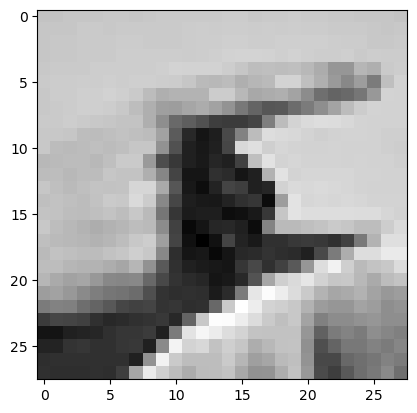

Classe prédite: F
Classe vraie  : F


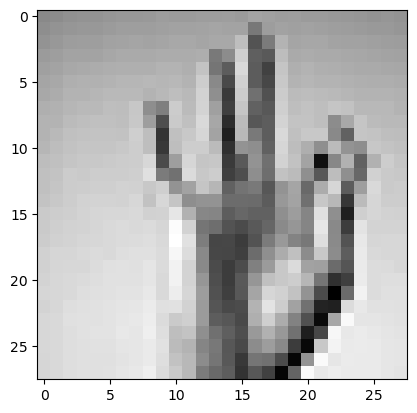

Classe prédite: K
Classe vraie  : K


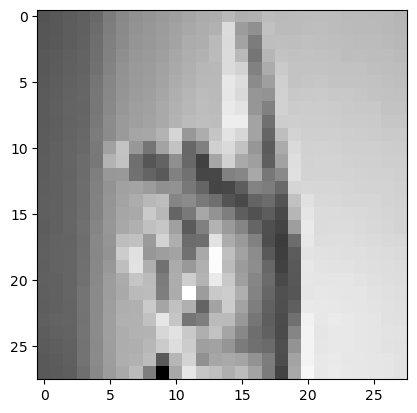

Classe prédite: A
Classe vraie  : A


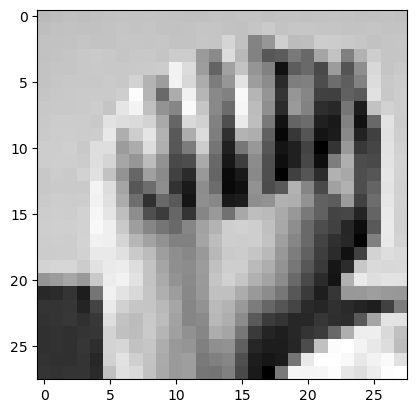

Classe prédite: D
Classe vraie  : D


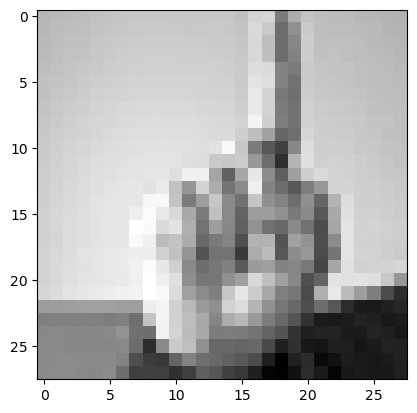

Classe prédite: V
Classe vraie  : V


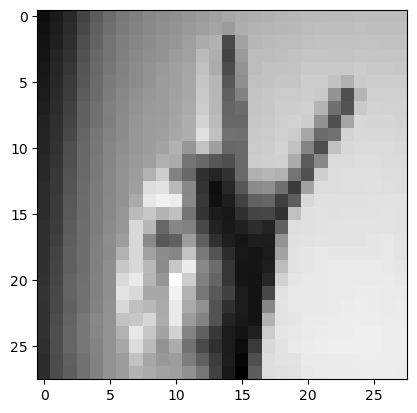

Classe prédite: K
Classe vraie  : K


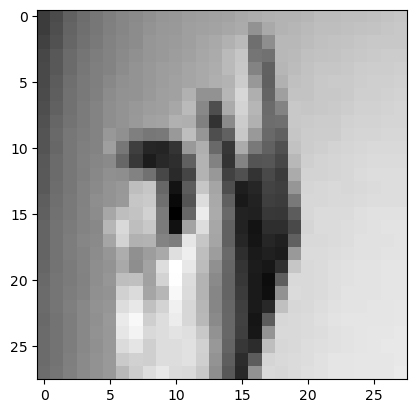

Classe prédite: O
Classe vraie  : O


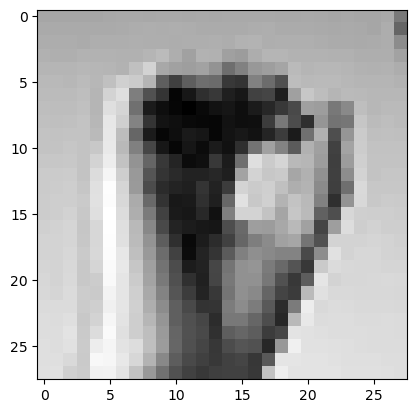

Classe prédite: D
Classe vraie  : D


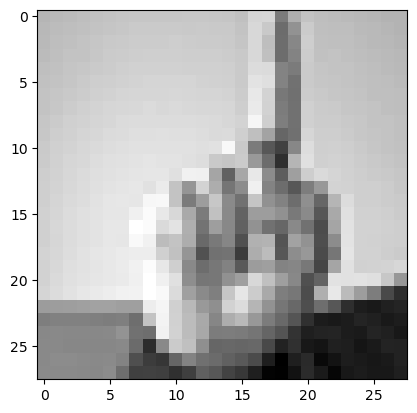

Classe prédite: H
Classe vraie  : H


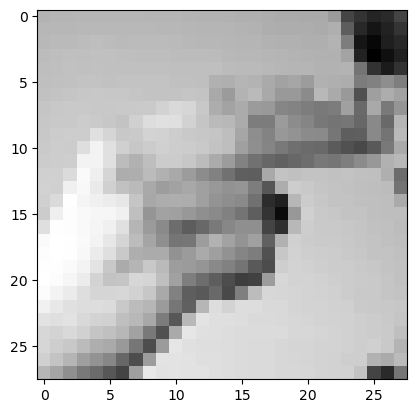

225/225 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - categorical_accuracy: 0.9282 - loss: 0.1841
{'CNN': {'Loss': 0.4290611147880554, 'Accuracy': 0.9187116622924805}, 'grid': {'Loss': 3.214338541030884, 'Accuracy': 0.5782208442687988}, 'CNN aug': {'Loss': 0.18224503099918365, 'Accuracy': 0.9276352524757385}}


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

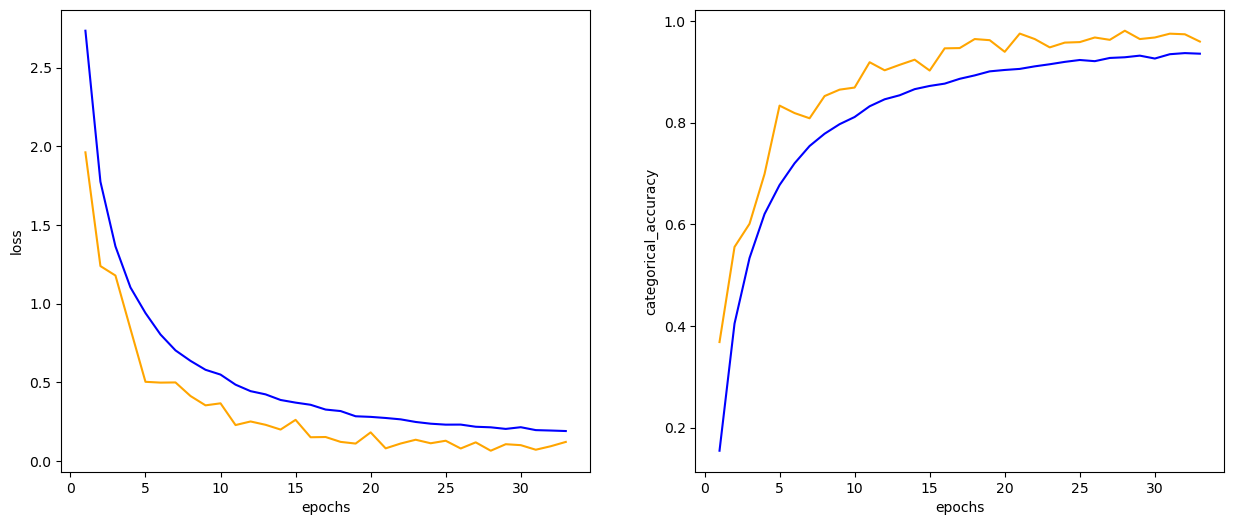

In [141]:
model_cnn_aug = create_cnn_aug_model()

history_cnn_aug = model_cnn_aug.fit(
    X_train_image,
    y_train_cat,
    epochs=40,
    validation_data=(X_val_image, y_val_cat),
    callbacks=[EarlyStopping(patience=5)]
)

evaluate_model(model_cnn_aug, "CNN aug", history_cnn_aug)

On a bien un plateau aux alentours de 0 pour le loss avec une courbe décroissante pour les données d'entrainement et de test.

On a bien une courbe croissante pour l'accuracy qui dépasse légèrement les 0.9 (ce qui est bien!)

In [142]:
performances

{'CNN': {'Loss': 0.4290611147880554, 'Accuracy': 0.9187116622924805},
 'grid': {'Loss': 3.214338541030884, 'Accuracy': 0.5782208442687988},
 'CNN aug': {'Loss': 0.18224503099918365, 'Accuracy': 0.9276352524757385}}

'CNN': {'Loss': 0.4290611147880554, 'Accuracy': 0.9187116622924805},

'CNN aug': {'Loss': 0.18224503099918365, 'Accuracy': 0.9276352524757385}

Donc on a: 
- La perte (loss) a été réduite, passant de 0.4290 à 0.1822 -> le modèle fait moins d'erreurs
- L'exactitude (accuracy) a quant à elle augmenté, passant de 91,87 % à 92,76 % -> le modèle est devenu plus précis.

L'augmentation d'images est une technique couramment utilisée pour améliorer la généralisation du modèle, en enrichissant l'ensemble de données d'entraînement avec des images modifiées (flips, rotations, zooms, translations, etc.). Cela permet au modèle d'apprendre à reconnaître les objets ou caractéristiques dans des contextes variés, le rendant plus robuste et moins sujet au sur-apprentissage (overfitting). Dans ce cas, l'augmentation a effectivement contribué à l'amélioration des performances.

/!\ J'ai dû drastiquement réduire les valeurs des changements pour que ce soit bénéfique
ex: avant j'avais `model.add(RandomRotation(0.1))`, je suis passée à `model.add(RandomRotation(0.05))`.

##### Grid augmenté

In [144]:
# Récupérer les meilleurs paramètres trouvés par GridSearchCV
# best_params = grid_cnn_model.best_params_

best_params = {'model__alpha': 0.0001, 'model__dropout_rate': 0.5, 'model__nb_conv_layers': 5, 'model__neurons': 64, 'model__optimizer': 'sgd'}


print(best_params)

def create_grid_cnn_aug_model(
    optimizer=best_params['model__optimizer'],
    dropout_rate=best_params['model__dropout_rate'],
    neurons=best_params['model__neurons'],
    nb_conv_layers=best_params['model__nb_conv_layers'],
    alpha=best_params['model__alpha']
):
    hyperparameters = {optimizer, dropout_rate, neurons, nb_conv_layers, alpha}
    print("Essais avec :", hyperparameters)
    model = Sequential()
    
    model.add(Input(shape=input_shape))

    # Transformation appliquée à chaque itération
    model.add(RandomFlip("horizontal"))
    model.add(RandomRotation(0.05))
    model.add(RandomZoom(height_factor=0.1))
    model.add(RandomTranslation(height_factor=0.05, width_factor=0.05))
    
    for i in range(nb_conv_layers):
        model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        model.add(BatchNormalization())  # Normalisation après chaque couche Conv
    
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Couches denses
    model.add(Flatten())
    model.add(Dense(neurons, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(26, activation='softmax'))  # 26 classes pour la sortie

    # Configuration de l'optimiseur avec le taux d'apprentissage (alpha)
    if optimizer == 'adam':
        opt = Adam(learning_rate=alpha)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=alpha)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=alpha, momentum=0.1)

    # Compilation du modèle
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

    return model

{'model__alpha': 0.0001, 'model__dropout_rate': 0.5, 'model__nb_conv_layers': 5, 'model__neurons': 64, 'model__optimizer': 'sgd'}


In [145]:
model_grid_cnn_aug = create_grid_cnn_aug_model()

history_grid_cnn_aug = model_grid_cnn_aug.fit(
    X_train_image,
    y_train_cat,
    epochs=40,
    validation_data=(X_val_image, y_val_cat),
    callbacks=[EarlyStopping(patience=10)]
)

evaluate_grid_model(model_grid_cnn_aug, "CNN grid aug", history_grid_cnn_aug)

Essais avec : {0.5, 64, 5, 'sgd', 0.0001}
Epoch 1/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 72ms/step - categorical_accuracy: 0.0477 - loss: 3.8428 - val_categorical_accuracy: 0.0842 - val_loss: 3.2306
Epoch 2/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - categorical_accuracy: 0.0663 - loss: 3.3311 - val_categorical_accuracy: 0.1057 - val_loss: 3.1323
Epoch 3/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - categorical_accuracy: 0.0854 - loss: 3.2233 - val_categorical_accuracy: 0.1469 - val_loss: 3.0351
Epoch 4/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 50s 73ms/step - categorical_accuracy: 0.0989 - loss: 3.1543 - val_categorical_accuracy: 0.1790 - val_loss: 2.9610
Epoch 5/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 49s 72ms/step - categorical_accuracy: 0.1141 - loss: 3.0756 - val_categorical_accuracy: 0.2034 - val_loss: 2.9026
Epoch 6/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 48s 71ms/step - categorical_accuracy: 0.1223 - loss: 3.0337 - val_categorical_accuracy: 0.2415 - val_loss: 2.7943
Epoch 7/40
675/675 ━━━━━━━━━━━━━━━

<!-- 'grid': {'Loss': 3.214338541030884, 'Accuracy': 0.5782208442687988},
'CNN grid aug': {'Loss': 0.5705568790435791, 'Accuracy': 0.8103736639022827 } -->

'grid': {'Loss': 3.214338541030884, 'Accuracy': 0.5782208442687988}
'CNN grid aug': {'Loss': 1.1676050424575806, 'Accuracy': 0.6592303514480591}

Donc on a: 
- La perte (loss) a été réduite, passant de 3.21 à 1.16 -> le modèle fait moins d'erreurs
- L'exactitude (accuracy) a quant à elle augmenté, passant de 57.8 % à 65.9 % -> le modèle est devenu plus précis.

L'augmentation d'images est une technique couramment utilisée pour améliorer la généralisation du modèle, en enrichissant l'ensemble de données d'entraînement avec des images modifiées (flips, rotations, zooms, translations, etc.). Cela permet au modèle d'apprendre à reconnaître les objets ou caractéristiques dans des contextes variés, le rendant plus robuste et moins sujet au sur-apprentissage (overfitting). Dans ce cas, l'augmentation a effectivement contribué à l'amélioration des performances.

/!\ J'ai dû drastiquement réduire les valeurs des changements pour que ce soit bénéfique
ex: avant j'avais `model.add(RandomRotation(0.1))`, je suis passée à `model.add(RandomRotation(0.05))`.

#### 7. Sauvegarder votre meilleur modèle.

In [146]:
performances

{'CNN': {'Loss': 0.4290611147880554, 'Accuracy': 0.9187116622924805},
 'grid': {'Loss': 3.214338541030884, 'Accuracy': 0.5782208442687988},
 'CNN aug': {'Loss': 0.18224503099918365, 'Accuracy': 0.9276352524757385},
 'CNN grid aug': {'Loss': 1.1676050424575806, 'Accuracy': 0.6592303514480591}}

Le meilleur modèle est le CNN augmenté.

In [42]:
import os

def save_best_model(performances, models, save_dir="saved_models"):
    # Créer un répertoire pour sauvegarder les modèles si nécessaire
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Trouver le modèle avec la meilleure exactitude
    best_model_name = None
    best_accuracy = 0

    for name, stats in performances.items():
        if stats["Accuracy"] > best_accuracy:
            best_accuracy = stats["Accuracy"]
            best_model_name = name

    # Si un modèle avec la meilleure exactitude a été trouvé, le sauvegarder
    if best_model_name:
        best_model = models[best_model_name]  # Récupérer le modèle dans l'objet models
        best_model_path = os.path.join(save_dir, f"best_model.keras")
        best_model.save(best_model_path)
        print(f"Meilleur modèle '{best_model_name}' sauvegardé à l'emplacement: {best_model_path}")
    else:
        print("Aucun modèle à sauvegarder.")

# Sauvegarder le modèle avec les meilleures performances
save_best_model(performances, models)

Meilleur modèle 'CNN aug' sauvegardé à l'emplacement: saved_models/best_model.keras


#### 8. Utiliser votre meilleur modèle avec des photos prises pour l'occasion où vous représenterez différents signes.

##### Afficher un exemple pour chaque lettre

Lettre : G


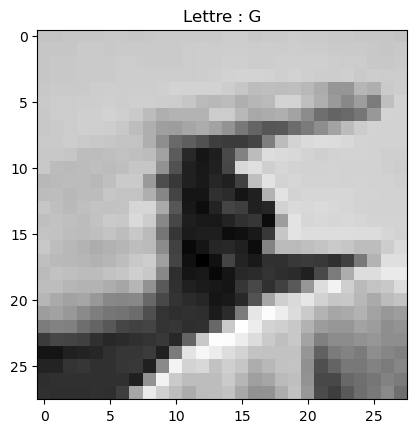

Lettre : F


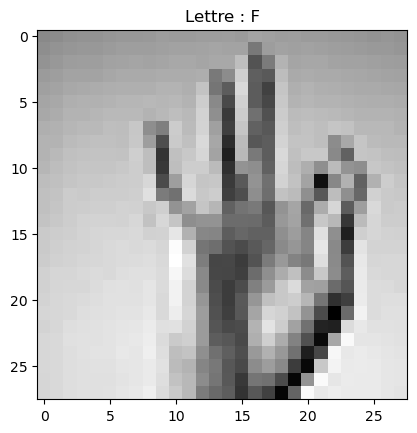

Lettre : K


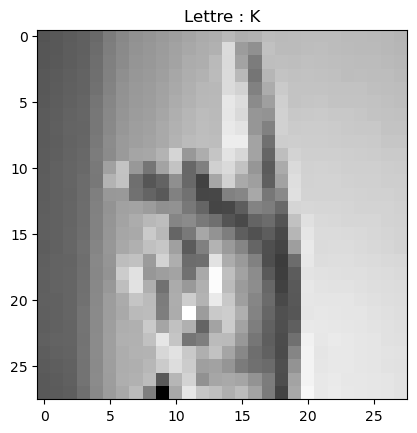

Lettre : A


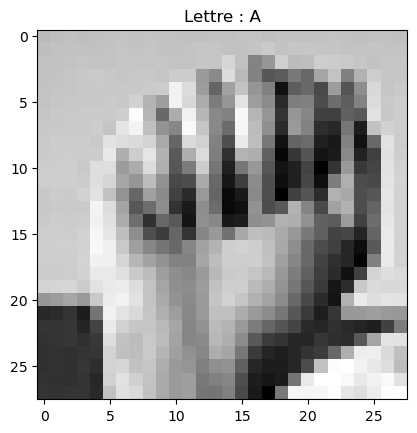

Lettre : D


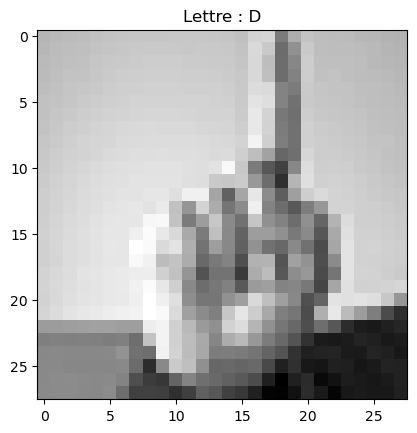

Lettre : V


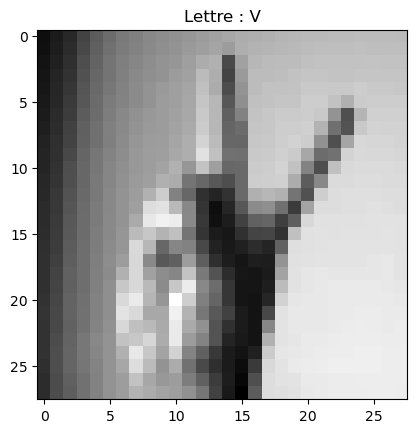

Lettre : O


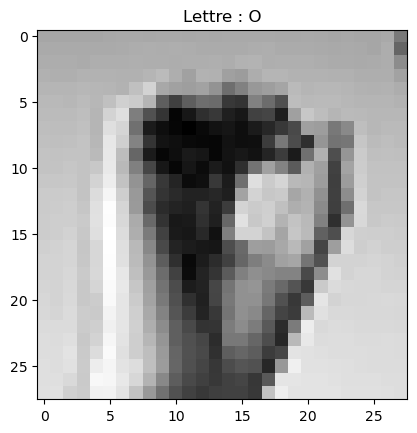

Lettre : H


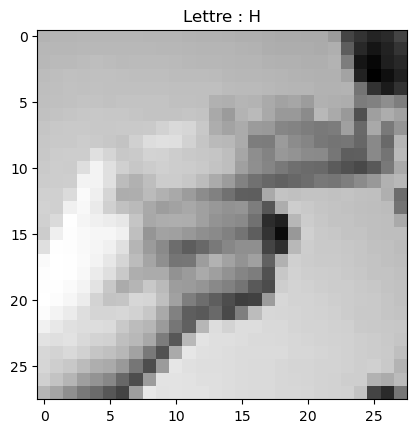

Lettre : I


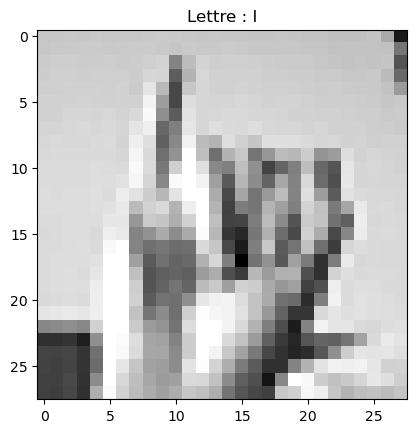

Lettre : M


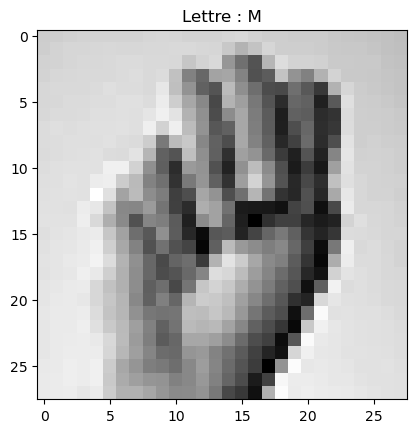

Lettre : E


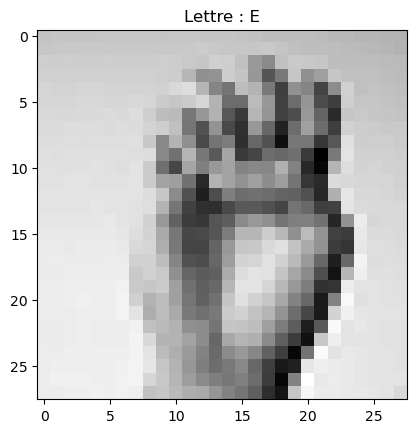

Lettre : W


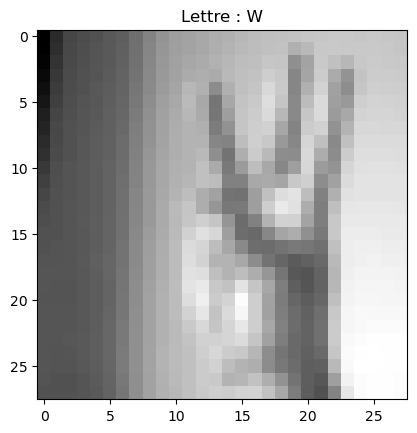

Lettre : C


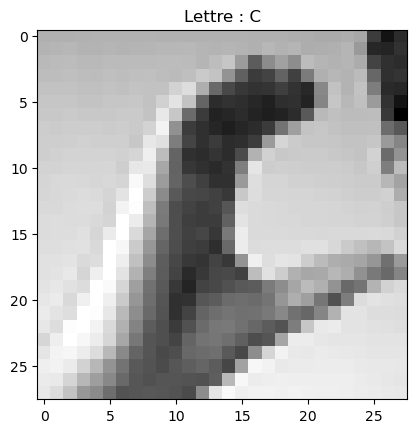

Lettre : P


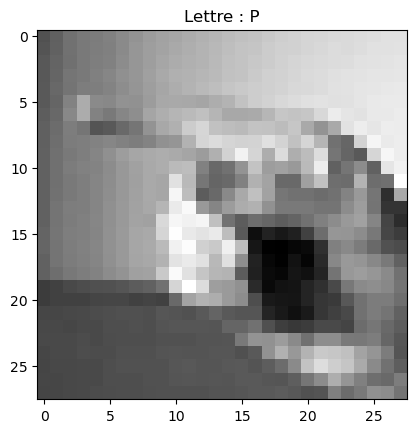

Lettre : B


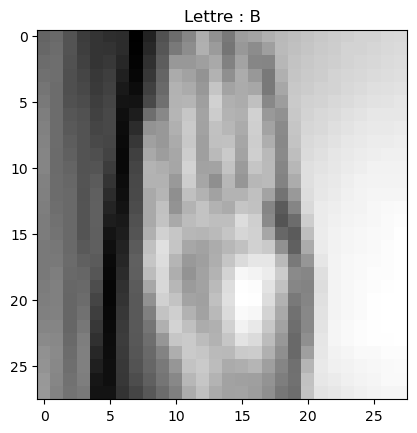

Lettre : N


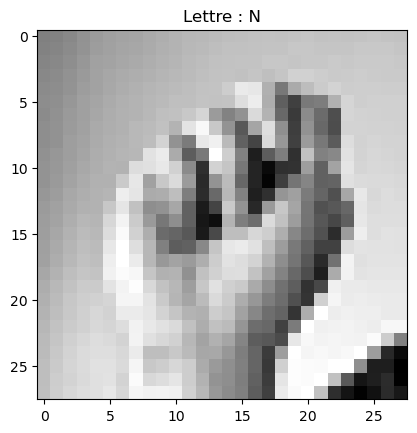

Lettre : T


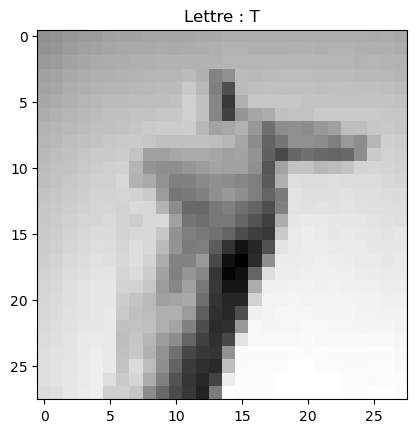

Lettre : S


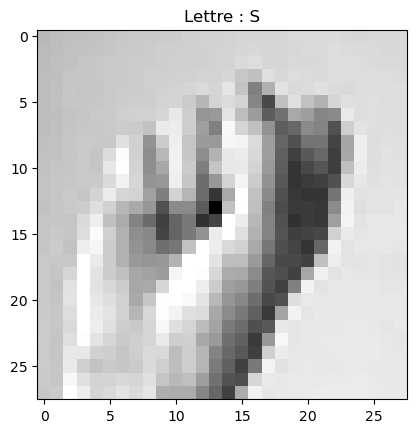

Lettre : X


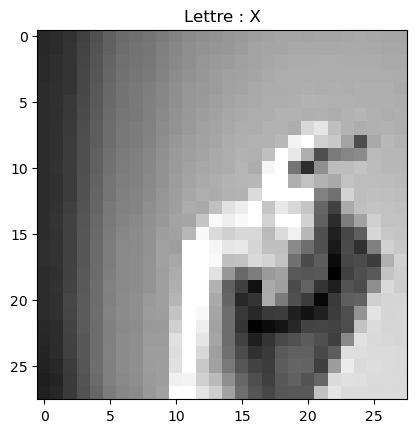

Lettre : R


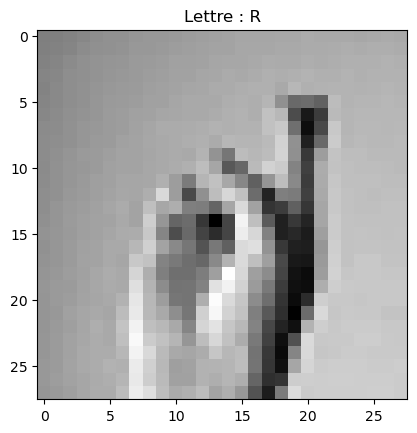

Lettre : U


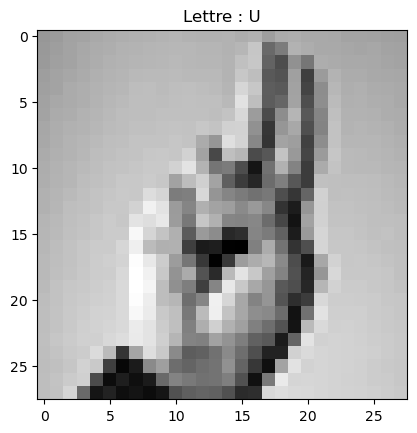

Lettre : Q


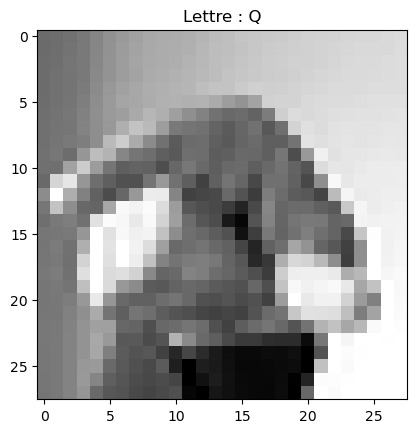

Lettre : L


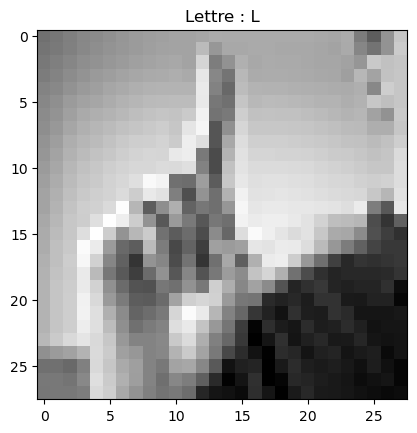

Lettre : Y


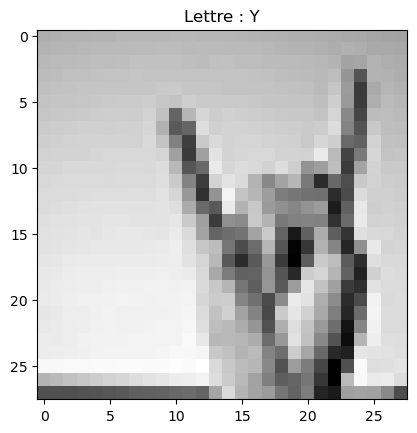

In [43]:
def show_first_image_per_class(X_test, y_test, labels):
    # Initialiser une liste pour savoir si on a déjà trouvé une observation pour chaque classe
    found_classes = np.zeros(26, dtype=bool)  # 26 classes pour l'alphabet de A à Z

    # Parcourir y_test pour trouver la première occurrence de chaque classe
    for i, label in enumerate(y_test):
        if not found_classes[label]:  # Si la classe n'a pas encore été trouvée
            found_classes[label] = True

            # Affichage de la lettre associée
            print(f"Lettre : {labels[label]}")

            # Affichage de l'image correspondante
            img = X_test[i]  # Accès direct avec l'index pour un numpy array
            plt.imshow(img.squeeze(), cmap="gray")  # .squeeze() pour enlever toute dimension de taille 1
            plt.title(f"Lettre : {labels[label]}")
            plt.show()

        # Si toutes les classes ont été trouvées, sortir de la boucle
        if all(found_classes):
            break

# Exemple d'utilisation (assurant que labels contient les lettres de A à Z)
show_first_image_per_class(X_test_image, y_test, labels)

##### Import des photos

In [44]:
from tensorflow.keras.models import load_model
from PIL import Image

# Charger le meilleur modèle sauvegardé
best_model_path = 'saved_models/best_model.keras'
best_model = load_model(best_model_path)

# Répertoire contenant les photos personnelles (utiliser un chemin relatif ou absolu)
photos_dir = 'photos'

# Lister toutes les images dans le dossier "photos"
image_files = [f for f in os.listdir(photos_dir) if f.endswith('.jpg')]

# Fonction de chargement et de prétraitement d'image
def load_and_preprocess_image(image_path, target_size=(28, 28)):
    # Charger l'image
    img = Image.open(image_path).convert('L')  # Convertir en niveaux de gris

    # Redimensionner l'image à la taille souhaitée
    img = img.resize(target_size)

    # Convertir l'image en tableau NumPy
    img_array = np.array(img)

    # Normaliser l'image (les valeurs de pixels entre 0 et 1)
    img_array = img_array / 255.0

    # Reshaper pour correspondre à l'entrée du modèle (28, 28, 1)
    img_array = img_array.reshape(1, 28, 28, 1)

    return img_array, img



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Image: 8.jpg
Classe attendue : I
Prédiction : D


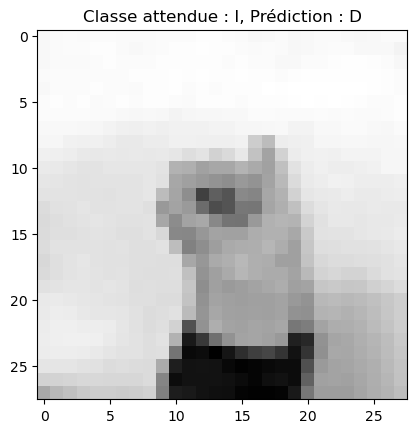

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 14.jpg
Classe attendue : O
Prédiction : G


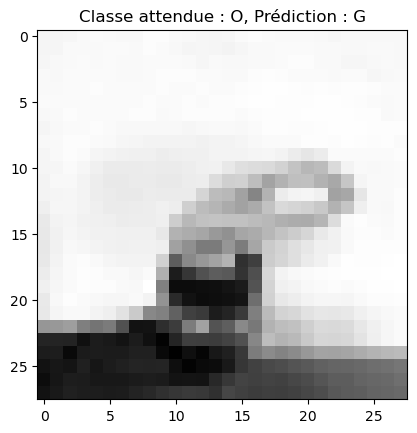

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 15.jpg
Classe attendue : P
Prédiction : P


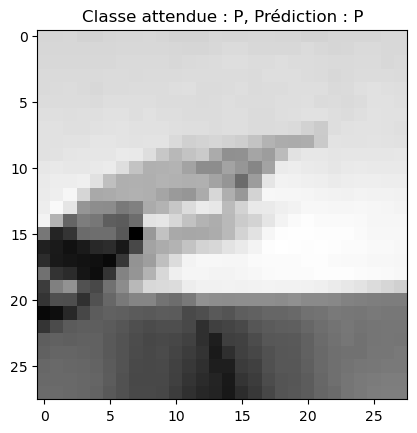

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 17.jpg
Classe attendue : R
Prédiction : N


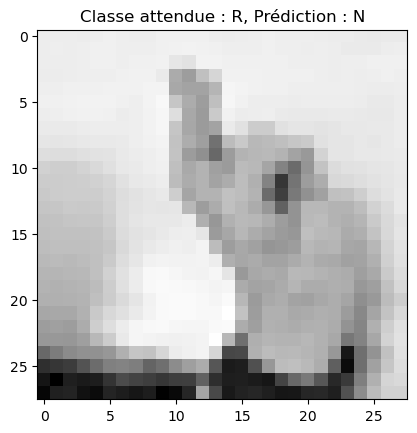

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 12.jpg
Classe attendue : M
Prédiction : X


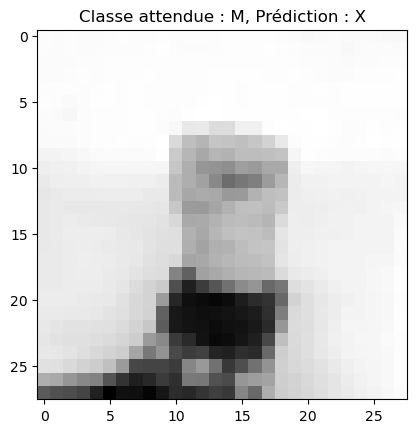

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Image: 13.jpg
Classe attendue : N
Prédiction : G


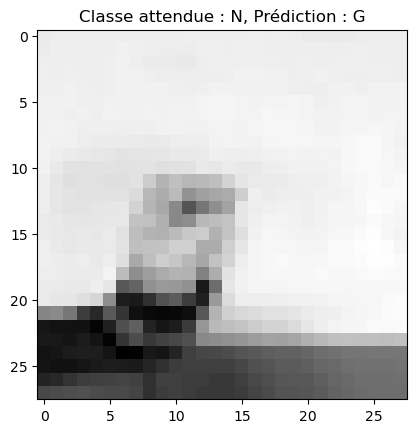

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 11.jpg
Classe attendue : L
Prédiction : T


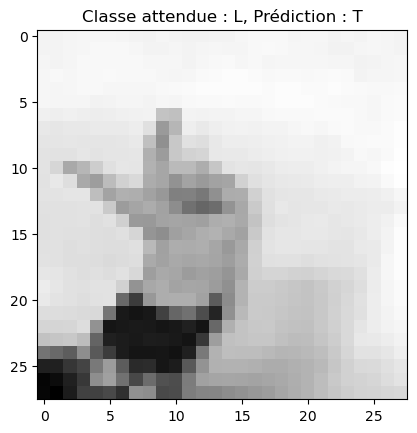

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 10.jpg
Classe attendue : K
Prédiction : X


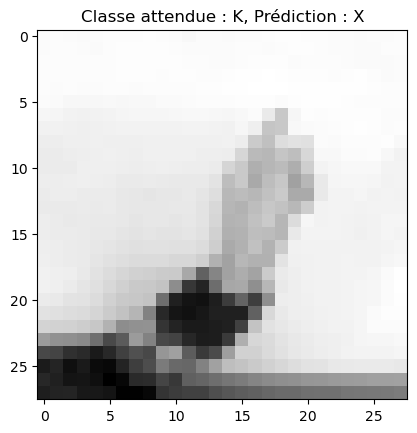

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 21.jpg
Classe attendue : V
Prédiction : N


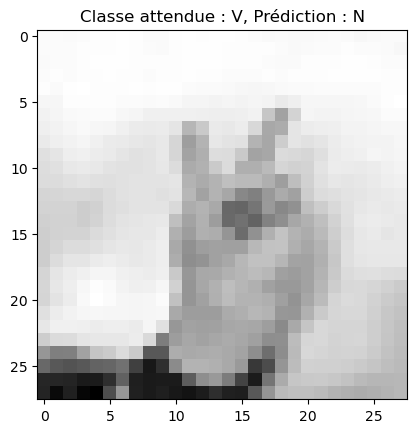

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 20.jpg
Classe attendue : U
Prédiction : N


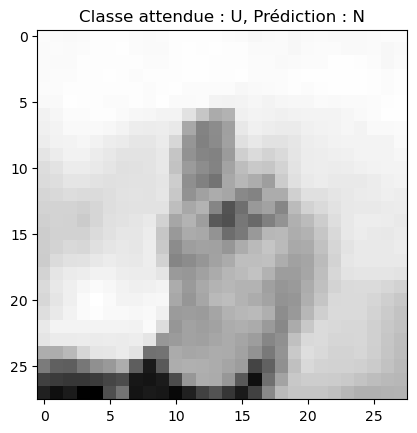

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 22.jpg
Classe attendue : W
Prédiction : I


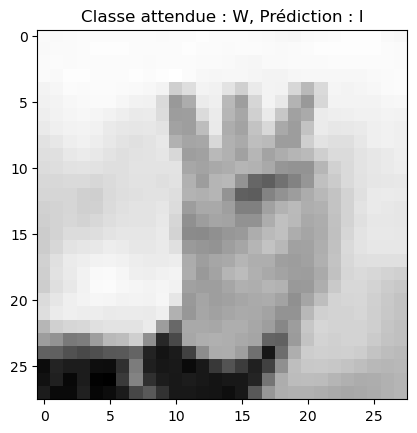

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 23.jpg
Classe attendue : X
Prédiction : Y


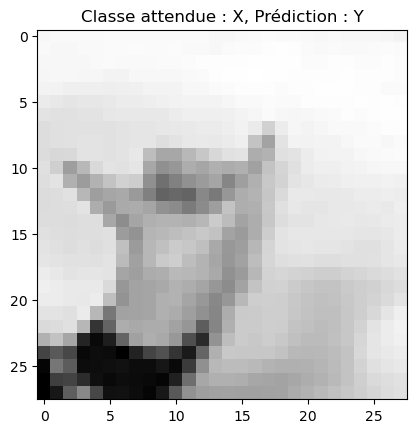

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 18.jpg
Classe attendue : S
Prédiction : D


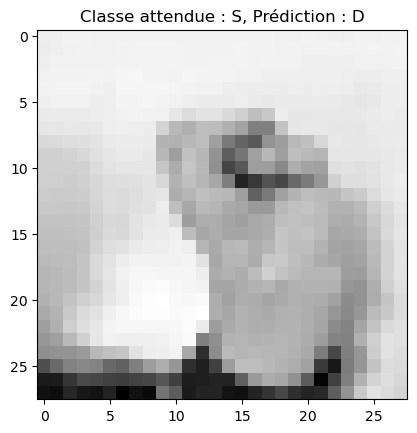

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 19.jpg
Classe attendue : T
Prédiction : D


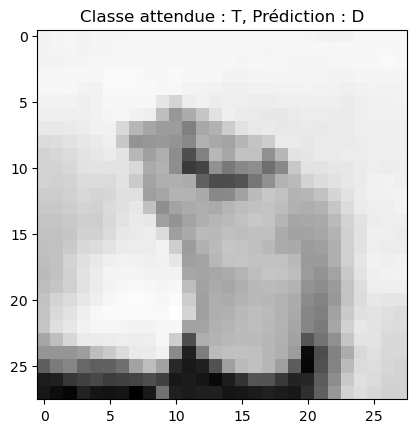

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Image: 4.jpg
Classe attendue : E
Prédiction : G


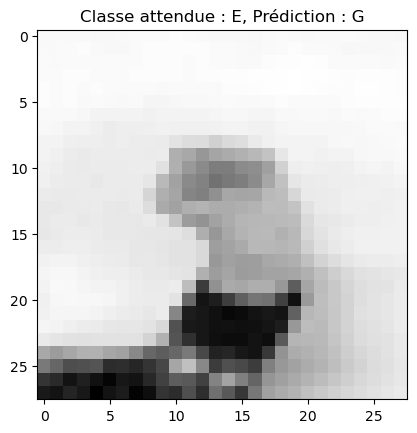

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 5.jpg
Classe attendue : F
Prédiction : H


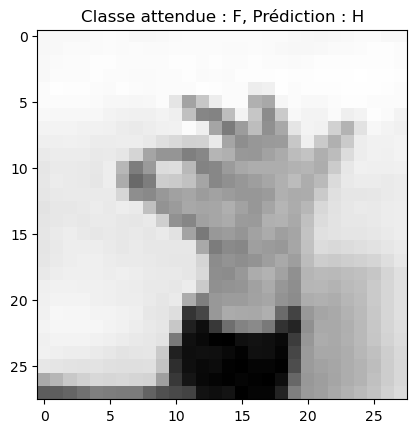

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 7.jpg
Classe attendue : H
Prédiction : H


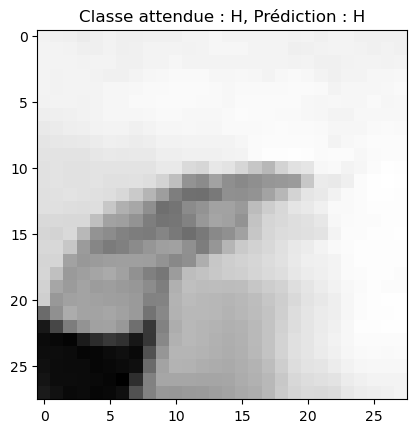

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 6.jpg
Classe attendue : G
Prédiction : G


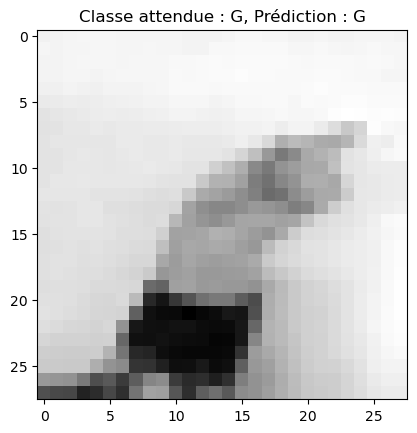

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Image: 2.jpg
Classe attendue : C
Prédiction : P


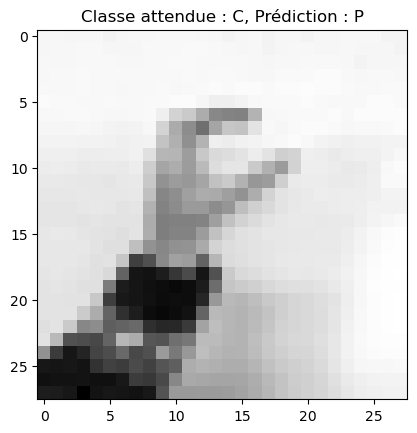

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 3.jpg
Classe attendue : D
Prédiction : H


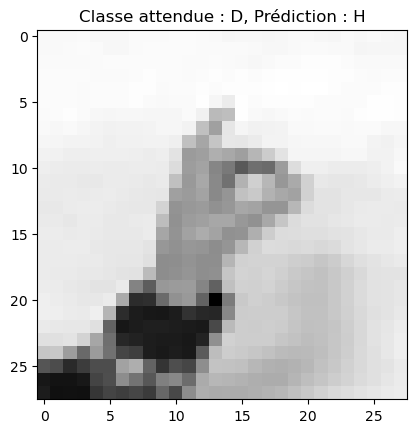

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Image: 1.jpg
Classe attendue : B
Prédiction : X


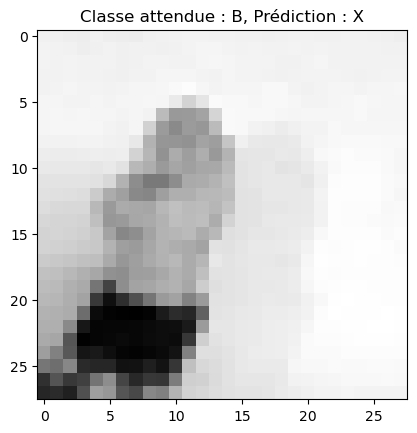

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Image: 0.jpg
Classe attendue : A
Prédiction : G


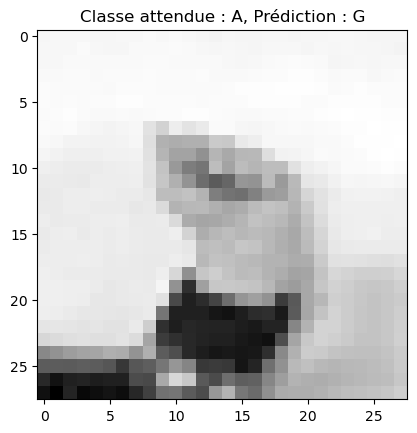

In [45]:
# Faire des prédictions sur chaque image
for image_file in image_files:
    image_path = os.path.join(photos_dir, image_file)

    # Charger et prétraiter l'image
    img_array, img_preprocessed = load_and_preprocess_image(image_path)

    # Extraire la classe attendue depuis le nom du fichier (ex: "0.jpg" pour A)
    expected_class = int(image_file.split('.')[0])
    expected_label = chr(65 + expected_class)  # Convertir en lettre (A=0, B=1, ..., Z=25)

    # Faire la prédiction avec le modèle chargé
    y_pred = best_model.predict(img_array)

    # Afficher le résultat de la prédiction
    predicted_class = np.argmax(y_pred)
    predicted_label = chr(65 + predicted_class)  # Convertir en lettre prédite

    # Afficher la lettre attendue, la lettre prédite, et l'image correspondante
    print(f"Image: {image_file}")
    print(f"Classe attendue : {expected_label}")
    print(f"Prédiction : {predicted_label}")
    
    # Afficher l'image en 28x28, en nuances de gris
    plt.imshow(img_preprocessed, cmap="gray")
    plt.title(f"Classe attendue : {expected_label}, Prédiction : {predicted_label}")
    plt.show()


#### 9. Choisir un des modèles pré-entrainés disponible avec Keras. Le charger et le personnaliser avec des couches de convolution et complètement connectées. L'entraîner et mesurer sa performance. La comparer avec celles de votre meilleur modèle.

In [46]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Resizing
from tensorflow.keras.optimizers import Adam

X_train_image_vgg16 = np.repeat(X_train_image, 3, axis=-1)
X_val_image_vgg16 = np.repeat(X_val_image, 3, axis=-1)
X_test_image_vgg16 = np.repeat(X_test_image, 3, axis=-1)

input_shape = X_train_image_vgg16.shape[1:]
input_shape

(28, 28, 3)

In [47]:
def create_model_from_vgg16():
    model = Sequential()

    # Étendre les canaux pour passer de 28x28x1 à 28x28x3
    model.add(Input(shape=(28, 28, 3)))
    model.add(Resizing(64, 64))  # Redimensionner les images à 64x64 pour éviter une réduction excessive

    # Charger VGG16 pré-entraîné
    vgg_base = VGG16(weights="imagenet", include_top=False, input_shape=(64, 64, 3))

    # Désactiver l'entraînement des couches de VGG16
    for layer in vgg_base.layers:
        layer.trainable = False

    model.add(vgg_base)

    # Ajouter des couches personnalisées
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(26, activation='softmax'))  # 26 classes pour la sortie

    # Compiler le modèle
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
    
    model.summary()
    return model

# Créer le modèle
model_vgg16 = create_model_from_vgg16()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 2, 2, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,986,906 (57.17 MB)

 Trainable params: 272,218 (1.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [48]:
history_vgg16 = model_vgg16.fit(
    X_train_image_vgg16,
    y_train_cat,
    epochs=40,
    validation_data=(X_val_image_vgg16, y_val_cat),
    callbacks=[EarlyStopping(patience=5)]
)

Epoch 1/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 165s 244ms/step - categorical_accuracy: 0.2395 - loss: 2.5218 - val_categorical_accuracy: 0.8813 - val_loss: 0.5914
Epoch 2/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 162s 240ms/step - categorical_accuracy: 0.6297 - loss: 1.0554 - val_categorical_accuracy: 0.9600 - val_loss: 0.2724
Epoch 3/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 160s 237ms/step - categorical_accuracy: 0.7494 - loss: 0.7216 - val_categorical_accuracy: 0.9783 - val_loss: 0.1537
Epoch 4/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 161s 239ms/step - categorical_accuracy: 0.7943 - loss: 0.5778 - val_categorical_accuracy: 0.9872 - val_loss: 0.0940
Epoch 5/40
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - categorical_accuracy: 0.8419 - loss: 0.4571

KeyboardInterrupt: 

225/225 ━━━━━━━━━━━━━━━━━━━━ 51s 224ms/step
Classe prédite: G
Classe vraie  : G


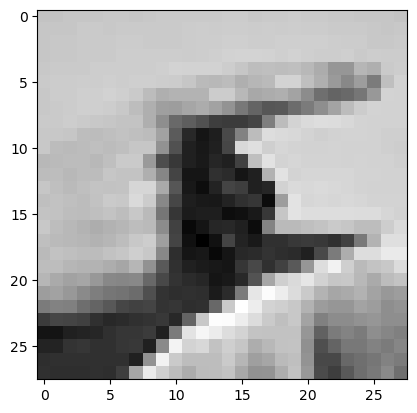

Classe prédite: F
Classe vraie  : F


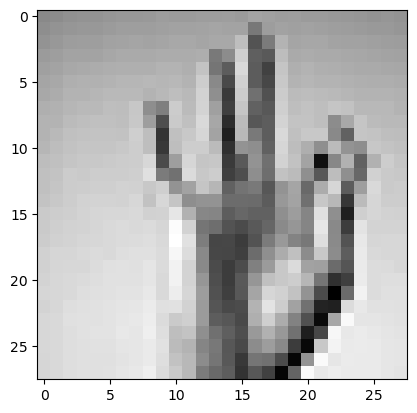

Classe prédite: K
Classe vraie  : K


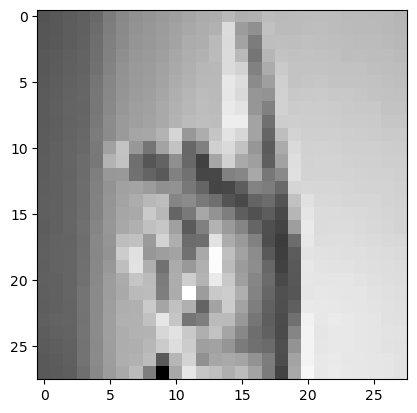

Classe prédite: A
Classe vraie  : A


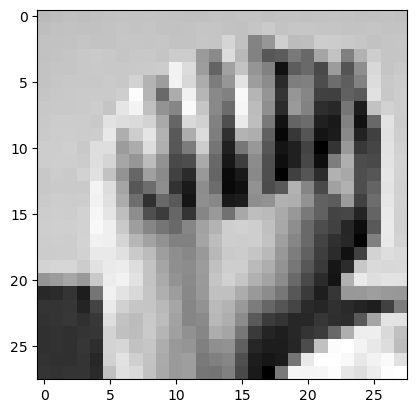

Classe prédite: D
Classe vraie  : D


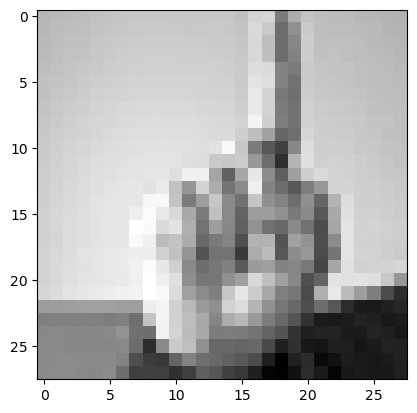

Classe prédite: V
Classe vraie  : V


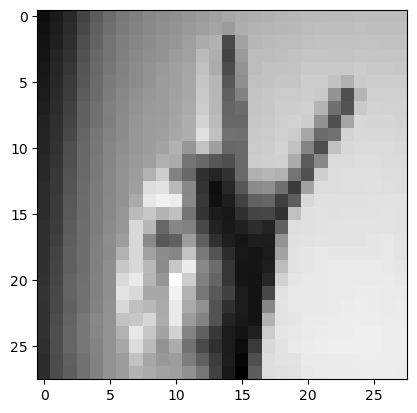

Classe prédite: K
Classe vraie  : K


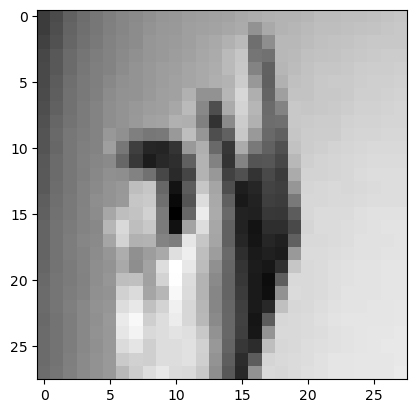

Classe prédite: O
Classe vraie  : O


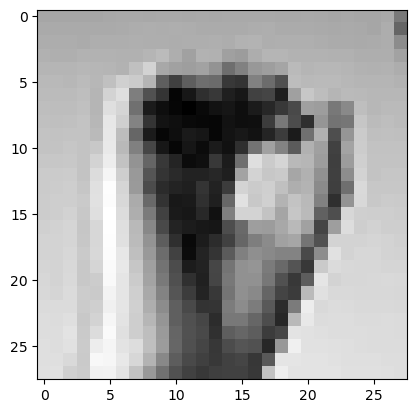

Classe prédite: D
Classe vraie  : D


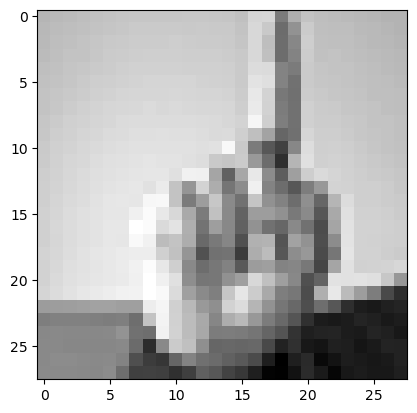

Classe prédite: H
Classe vraie  : H


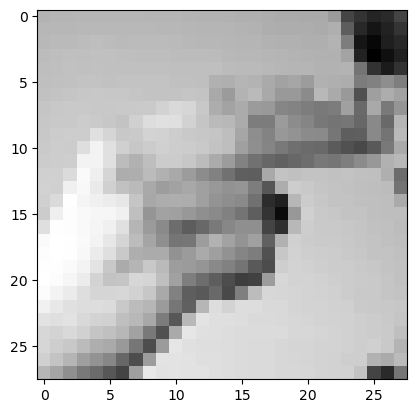

Modèle : VGG16 personnalisé


NameError: name 'plot_metrics' is not defined

In [181]:
def evaluate_vgg_model(model, name, history):
    # Convertir X_test_norm en 3 canaux si ce n'est pas déjà le cas
    if X_test_image.shape[-1] == 1:
        X_test_image_vgg16 = np.repeat(X_test_image, 3, axis=-1)  # Créer 3 canaux à partir de 1 seul
    
    # Effectuer les prédictions avec les données correctement formatées
    y_pred = model.predict(X_test_image_vgg16)

    # Comparer les étiquettes prédites et les étiquettes réelles
    compare_predict_true_labels(y_pred)

    # Afficher la structure du modèle
    plot_model(
        model,
        show_shapes=True,
        show_layer_activations=True,
        show_trainable=True)

    # Évaluer le modèle avec les données formatées
    loss, categorical_accuracy = model.evaluate(X_test_image_vgg16, y_test_cat)
    performances[name] = {"Loss" : loss, "Accuracy": categorical_accuracy}
    
    # Ajouter le modèle à l'objet models
    models[name] = model

    # Tracer l'historique
    plot_history(history)
    print(performances)

# Utiliser cette fonction pour évaluer le modèle
evaluate_vgg_model(model_vgg16, "VGG16 personnalisé", history_vgg16)